In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, Subset
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error
import json
from tqdm import tqdm
import torch.nn.functional as F  # Add this import at the top
import joblib  # Add this import at the top
import os
import sys
from torch.utils.data import DataLoader, random_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
import json  # Import the json module


# Get the notebook's directory
notebook_dir = os.getcwd()
# Add parent directory to path
project_root = os.path.dirname(notebook_dir)
sys.path.append(project_root)

# %% [markdown]
#  checking if the MPS (Metal Performance Shaders) backend is available

# %%
# Check if MPS is available
if not torch.backends.mps.is_available():
    raise RuntimeError("MPS device not available. Check if PyTorch and macOS set up correctly.")

# Set the device to MPS
device = torch.device("mps")  # Use GPU on M2 Pro

In [2]:
# Import the objective function (assuming it's defined in 'optim_functions.py')
#from optim_functions import objective
from QKD_Functions.QKD_Functions import (
calculate_factorial,
calculate_tau_n,
    calculate_eta_ch,
    calculate_eta_sys,
    calculate_D_mu_k,
    calculate_n_X_total,
    calculate_N,
    calculate_n_Z_total,
    calculate_e_mu_k,
    calculate_e_obs,
    calculate_h,
    calculate_lambda_EC,
    calculate_sqrt_term,
    calculate_tau_n,
    calculate_n_pm, 
    calculate_S_0,
    calculate_S_1,
    calculate_m_mu_k,
    calculate_m_pm,
    calculate_v_1,
    calculate_gamma,
    calculate_Phi,
    calculate_LastTwoTerm,
    calculate_l,
    calculate_R,
    experimental_parameters,
    other_parameters,
    calculate_key_rates_and_metrics,
    penalty, 
    objective,
)

/Users/daai6ga1hou2/anaconda3/envs/qkd-training_set/lib/python3.9/site-packages/tqdm_joblib/__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
# Load dataset
with open('../Training_Data/n_X/good/cleaned_combined_datasets.json', 'r') as f:
    data_by_nx = json.load(f)

print(f"The overall dataset contains {len(data_by_nx)} entries.")

# Verify the length of the list associated with the first key
first_key = list(data_by_nx.keys())[0]
print(f"The number of entries associated with the first key ({first_key}) is: {len(data_by_nx[first_key])}")

# Flatten the data structure and filter
cleaned_data = []
for n_x, entries in data_by_nx.items():
    cleaned_data.extend([
        item for item in entries
    if item["key_rate"] > 0 and item["e_1"] * 100 <= 200
])

# Optional: Verify the cleaned dataset
if not cleaned_data:
    print("No valid data after filtering.")
else:
    print(f"Filtered dataset contains {len(cleaned_data)} entries.")
    print("\nSample entry from the cleaned dataset:")
    print(json.dumps(cleaned_data[0], indent=2))
    print("\nNumber of unique n_X values:", len(data_by_nx))

The overall dataset contains 6 entries.
The number of entries associated with the first key (10000.0) is: 736
Filtered dataset contains 5310 entries.

Sample entry from the cleaned dataset:
{
  "fiber_length": 0.0,
  "e_1": 0.0,
  "e_2": 6.221848749616356,
  "e_3": 0.5,
  "e_4": 4.0,
  "key_rate": 0.00037995895580899045,
  "optimized_params": {
    "mu_1": 0.6126301275287198,
    "mu_2": 0.13818683663411718,
    "P_mu_1": 0.04604299826386499,
    "P_mu_2": 0.6110117432731096,
    "P_X_value": 0.414731486913827
  }
}

Number of unique n_X values: 6


In [4]:
X = np.array([[item['e_1'], item['e_2'], item['e_3'], item['e_4']] for item in cleaned_data])
Y = np.array([[item['optimized_params']['mu_1'], item['optimized_params']['mu_2'], item['optimized_params']['P_mu_1'], item['optimized_params']['P_mu_2'], item['optimized_params']['P_X_value']] for item in cleaned_data])

from sklearn.utils import shuffle

X, Y = shuffle(X, Y, random_state=42)

scaler = StandardScaler()
X = scaler.fit_transform(X)  # Fit and transform on training data

y_scaler = MinMaxScaler()  # Scale targets to [0, 1]
Y = y_scaler.fit_transform(Y)

# Save the scalers
joblib.dump(scaler, 'scaler.pkl')  # Save StandardScaler
joblib.dump(y_scaler, 'y_scaler.pkl')  # Save MinMaxScaler

print(f"X shape: {X.shape}, Y shape: {Y.shape}")
dataset = TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32))

X shape: (5310, 4), Y shape: (5310, 5)


In [5]:
# Assuming 'dataset' is your full dataset
train_size = int(0.8 * len(dataset))  # 70% of the dataset for training
val_size = len(dataset) - train_size  # 15% for validation

# Use random_split to split dataset into train, validation, and test sets
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True) 

In [6]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class BB84NN(nn.Module):
    def __init__(self):
        super(BB84NN, self).__init__()
        self.fc1 = nn.Linear(4, 16)
        self.fc2 = nn.Linear(16, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 5)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [7]:
# Initialize model
model = BB84NN().to(device)
criterion = nn.MSELoss() # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=1e-2)  # Adam optimizer
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=20)
# scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

In [8]:
# Load evaluation data
with open("../n_X/good/5e8_100_reordered_qkd_grouped_dataset_20250226_191349.json", 'r') as f:
    evaluation_dataset = json.load(f)

# Select target n_X for evaluation
target_nx = 5 * 100000000  # 5e8
nx_key = str(float(target_nx))
if nx_key not in evaluation_dataset:
    raise ValueError(f"No data found for n_X = {target_nx}")
evaluation_data = evaluation_dataset[nx_key]

# Extract evaluation fiber lengths and optimized parameters
fiber_lengths = np.array([entry["fiber_length"] for entry in evaluation_data])
optimized_params_array = np.array([list(entry["optimized_params"].values()) for entry in evaluation_data])

# Compute optimized key rates for evaluation
optimized_key_rates = []
for params, L in zip(optimized_params_array, fiber_lengths):
    key_rate = objective(params, L, target_nx, alpha=0.2, eta_Bob=0.1, P_dc_value=6e-7, epsilon_sec=1e-10, epsilon_cor=1e-15, f_EC=1.16, e_mis=5e-3, P_ap=0, n_event=1)[0]
    optimized_key_rates.append(key_rate)
optimized_key_rates = np.array(optimized_key_rates)

In [9]:
# Prepare test inputs for evaluation (using the same structure as your training data)
X_test = []
for L in fiber_lengths:
    e_1 = L / 100
    e_2 = -np.log10(6e-7)
    e_3 = 5e-3 * 100
    e_4 = np.log10(target_nx)
    X_test.append([e_1, e_2, e_3, e_4])

X_test = np.array(X_test)
X_test_scaled = scaler.transform(X_test)  # Use the SAME scaler fitted on TRAINING data
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Lists to store metrics
train_losses = []
val_losses = []
learning_rates = []

In [10]:
# # Function to create and save key rate and parameters plot
# def plot_keyrate_and_parameters(fiber_lengths, optimized_key_rates, optimized_params_array,
#                                  predicted_key_rates, predicted_params_array, epoch, filename, learning_rates):
#     """Plots key rate and parameter comparison and saves the figure."""
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
#     # Conditionally plot predicted key rates if they are available
#     if predicted_key_rates is not None and len(predicted_key_rates) > 0:
#         ax1.plot(fiber_lengths, np.log10(predicted_key_rates), 'r--', marker = 'o', label="Predicted Key Rate (NN)")

#     ax1.plot(fiber_lengths, np.log10(optimized_key_rates), label='Optimized Key Rate') # Plot real data.

#     ax1.set_title('Comparison of Key Rates')
#     ax1.set_xlabel('Fiber Length (km)')
#     ax1.set_ylabel('Secret Key Rate per Pulse')
#     ax1.legend()
#     ax1.grid(True)

#     # Plot parameters comparison on the right
#     labels = ['$\mu_1$', '$\mu_2$', '$P_{\mu_1}$', '$P_{\mu_2}$', '$P_X$']
#     colors = ['blue', 'green', 'red', 'purple', 'orange']
#     for i in range(5):
#         ax2.plot(fiber_lengths, optimized_params_array[:, i], label=f'Optimized {labels[i]}', color=colors[i], linestyle='-')
#         ax2.plot(fiber_lengths, predicted_params_array[:, i], label=f'Predicted {labels[i]}', marker = 'o', color=colors[i], linestyle='-')

#     ax2.set_title('Comparison of Parameters')
#     ax2.set_xlabel('Fiber Length (km)')
#     ax2.set_ylabel('Parameter Values')
#     ax2.set_xlim([0, 200]) 
#     ax2.legend()
#     ax2.grid(True)

#     plt.tight_layout()
#     plt.savefig(filename)
#     plt.show()
#     print(f"Plot saved to {filename}")

In [11]:
# Function to create and save key rate and parameters plot
def plot_keyrate_and_parameters(fiber_lengths, optimized_key_rates, optimized_params_array,
                                predicted_key_rates, predicted_params_array, epoch, filename, learning_rates):
    """Plots key rate and parameter comparison and saves the figure."""
    # Debug: Print key rates to diagnose the issue
    print(f"Epoch {epoch}: Predicted Key Rates: {predicted_key_rates[:10]}")  # Print first 10 values
    print(f"Epoch {epoch}: Optimized Key Rates: {optimized_key_rates[:10]}")  # Print first 10 values

    # Find the index where the optimized key rate becomes non-positive (or very small)
    threshold = 1e-8  # Practical threshold based on previous plots
    cutoff_idx = np.where(optimized_key_rates <= threshold)[0]
    if len(cutoff_idx) > 0:
        cutoff_idx = cutoff_idx[0]  # Take the first index where key rate <= threshold
    else:
        cutoff_idx = len(fiber_lengths)  # If no non-positive key rates, use the full length

    # Truncate data for the key rates plot (left panel)
    fiber_lengths_key = fiber_lengths[:cutoff_idx]
    optimized_key_rates = optimized_key_rates[:cutoff_idx]
    predicted_key_rates = predicted_key_rates[:cutoff_idx]

    # Truncate data for the parameters plot (right panel) to match the key rates
    fiber_lengths_params = fiber_lengths[:cutoff_idx]
    optimized_params_array = optimized_params_array[:cutoff_idx]
    predicted_params_array = predicted_params_array[:cutoff_idx]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    # Plot key rates (left panel)
    if predicted_key_rates is not None and len(predicted_key_rates) > 0:
        ax1.plot(fiber_lengths_key, np.log10(predicted_key_rates), 'r--', marker='o', label="Predicted Key Rate (NN)")
    ax1.plot(fiber_lengths_key, np.log10(optimized_key_rates), label='Optimized Key Rate')
    ax1.set_title('Comparison of Key Rates')
    ax1.set_xlabel('Fiber Length (km)')
    ax1.set_ylabel('Secret Key Rate per Pulse')
    ax1.legend()
    ax1.grid(True)

    # Plot parameters (right panel)
    labels = ['$\mu_1$', '$\mu_2$', '$P_{\mu_1}$', '$P_{\mu_2}$', '$P_X$']
    colors = ['blue', 'green', 'red', 'purple', 'orange']
    for i in range(5):
        ax2.plot(fiber_lengths_params, optimized_params_array[:, i], label=f'Optimized {labels[i]}', color=colors[i], linestyle='-')
        ax2.plot(fiber_lengths_params, predicted_params_array[:, i], label=f'Predicted {labels[i]}', marker='o', color=colors[i], linestyle='-')
    ax2.set_title('Comparison of Parameters')
    ax2.set_xlabel('Fiber Length (km)')
    ax2.set_ylabel('Parameter Values')
    ax2.set_xlim([0, fiber_lengths_params[-1] if len(fiber_lengths_params) > 0 else 200])  # Dynamically set x-axis limit
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.savefig(filename)
    plt.show()
    print(f"Plot saved to {filename}")

Epoch 1/5000, Train Loss: 0.0344, Val Loss: 0.0042
Epoch 0: Predicted Key Rates: [0.01159357 0.0105518  0.00960778 0.00874935 0.00796854 0.00725811
 0.00661158 0.00602307 0.00548724 0.00499933]
Epoch 0: Optimized Key Rates: [0.01212099 0.01101292 0.01000855 0.00909776 0.00827148 0.00752159
 0.00684078 0.0062225  0.00566083 0.00515046]


/var/folders/8m/0wg1hssn6n79tjc8mh6p_spr0000gn/T/ipykernel_87229/2488028585.py:30: RuntimeWarning: invalid value encountered in log10
  ax1.plot(fiber_lengths_key, np.log10(predicted_key_rates), 'r--', marker='o', label="Predicted Key Rate (NN)")


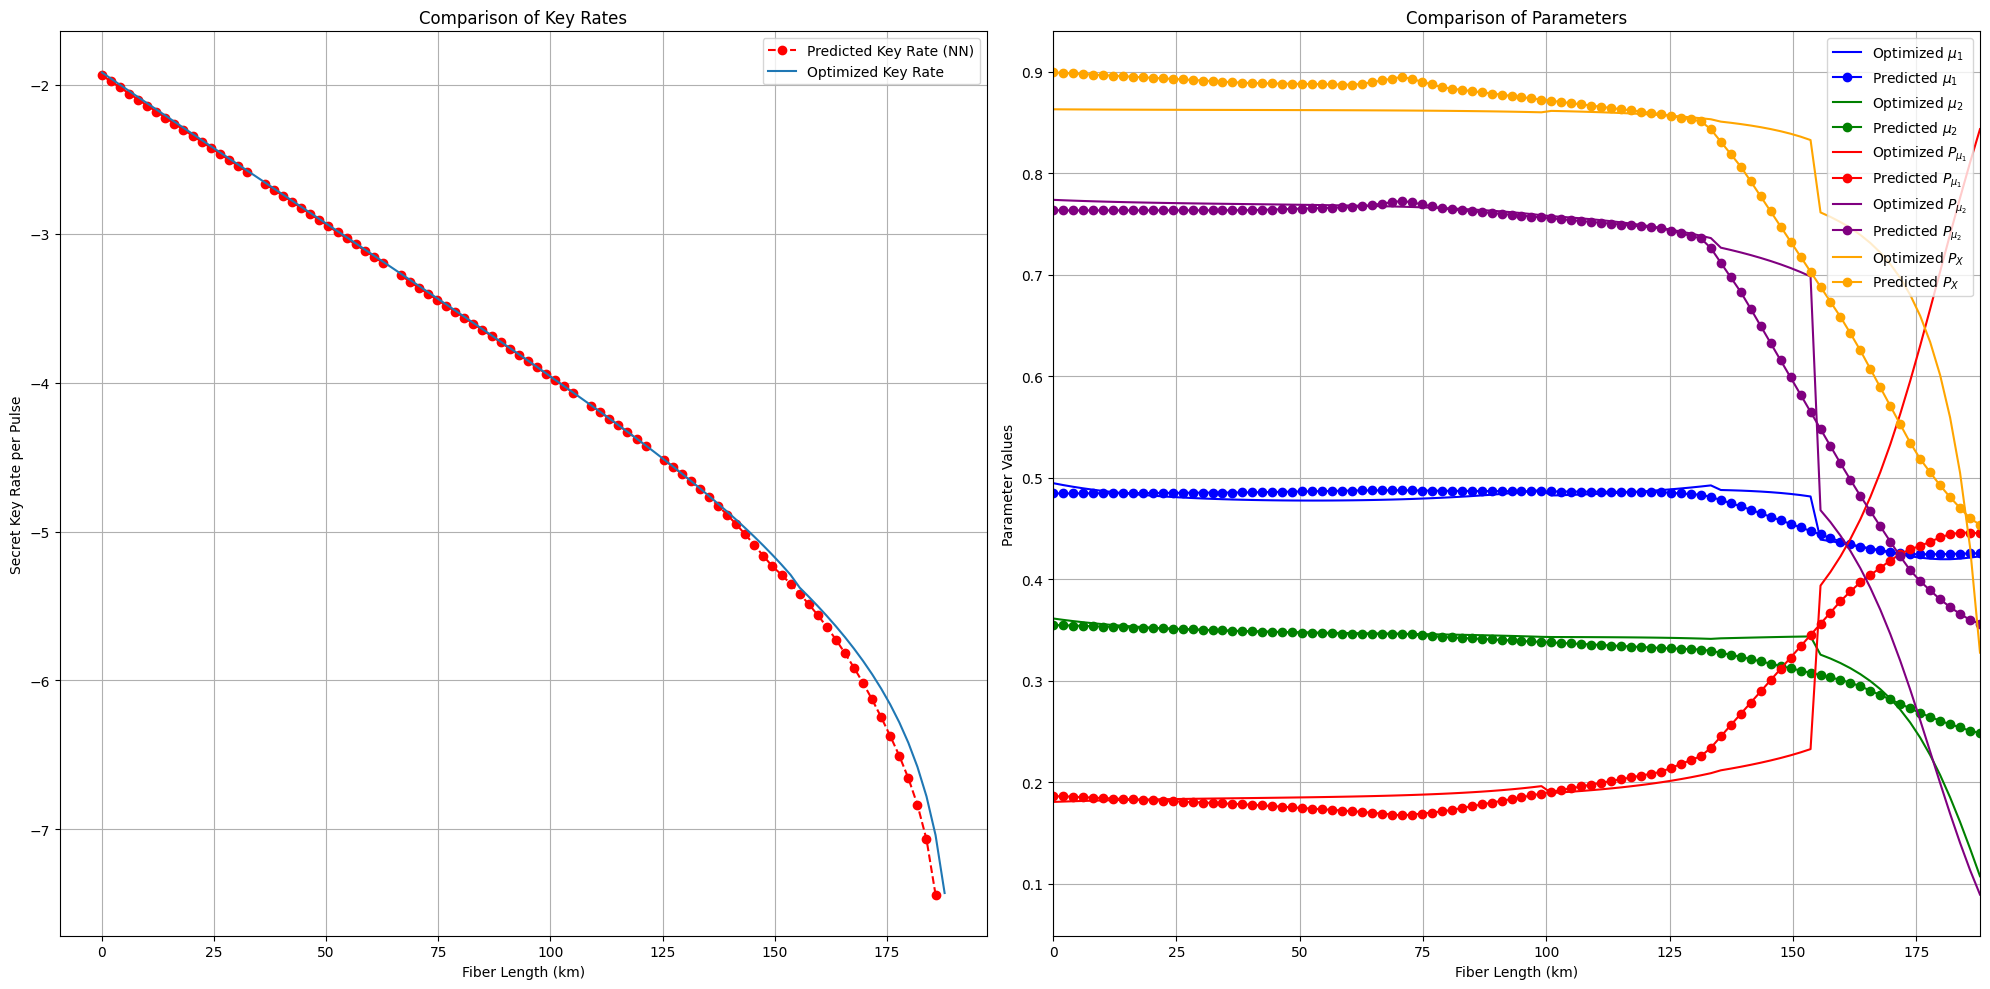

Plot saved to keyrate_parameters_first_epoch.png
Epoch 2/5000, Train Loss: 0.0030, Val Loss: 0.0019
Epoch 3/5000, Train Loss: 0.0017, Val Loss: 0.0012
Epoch 4/5000, Train Loss: 0.0010, Val Loss: 0.0009
Epoch 5/5000, Train Loss: 0.0009, Val Loss: 0.0007
Epoch 6/5000, Train Loss: 0.0008, Val Loss: 0.0009
Epoch 7/5000, Train Loss: 0.0007, Val Loss: 0.0007
Epoch 8/5000, Train Loss: 0.0007, Val Loss: 0.0006
Epoch 9/5000, Train Loss: 0.0008, Val Loss: 0.0006
Epoch 10/5000, Train Loss: 0.0006, Val Loss: 0.0007
Epoch 11/5000, Train Loss: 0.0006, Val Loss: 0.0006
Epoch 12/5000, Train Loss: 0.0006, Val Loss: 0.0005
Epoch 13/5000, Train Loss: 0.0006, Val Loss: 0.0005
Epoch 14/5000, Train Loss: 0.0005, Val Loss: 0.0006
Epoch 15/5000, Train Loss: 0.0006, Val Loss: 0.0008
Epoch 16/5000, Train Loss: 0.0005, Val Loss: 0.0006
Epoch 17/5000, Train Loss: 0.0006, Val Loss: 0.0005
Epoch 18/5000, Train Loss: 0.0005, Val Loss: 0.0005
Epoch 19/5000, Train Loss: 0.0005, Val Loss: 0.0008
Epoch 20/5000, Train Lo

In [12]:
first_epoch_predicted_params_array = None
first_epoch_predicted_key_rates = None

# Training loop
num_epochs = 5000
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_running_loss += loss.item() * inputs.size(0)
    val_loss = val_running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)

    # Update learning rate
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)    
    
    # # Learning rate scheduler step
    # scheduler.step(val_loss)

    # # Store the current learning rate
    # for param_group in optimizer.param_groups:
    #     learning_rates.append(param_group['lr'])

    # Print epoch results
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Evaluate and Plot
    model.eval()
    with torch.no_grad():
        # Make predictions
        X_test_tensor = X_test_tensor.to(device)
        predicted_params_scaled = model(X_test_tensor).cpu().numpy()
        predicted_params = y_scaler.inverse_transform(predicted_params_scaled)  # Inverse transform

        # Compute key rates using the predicted parameters
        predicted_key_rates = []
        for params, L in zip(predicted_params, fiber_lengths):
            key_rate = objective(params, L, target_nx, alpha=0.2, eta_Bob=0.1, P_dc_value=6e-7, epsilon_sec=1e-10, epsilon_cor=1e-15, f_EC=1.16, e_mis=5e-3, P_ap=0, n_event=1)[0]
            predicted_key_rates.append(key_rate)
        predicted_key_rates = np.array(predicted_key_rates)

        # Plot key rate and parameters for the first epoch
        if epoch == 0:
            plot_keyrate_and_parameters(fiber_lengths, optimized_key_rates, optimized_params_array,
                                         predicted_key_rates, predicted_params, epoch, 'keyrate_parameters_first_epoch.png', learning_rates)


Epoch 4999: Predicted Key Rates: [-1.00000000e+250  1.09964529e-002  9.99417847e-003  9.08475537e-003
  8.25960626e-003  7.51235837e-003  6.83352696e-003  6.21671624e-003
  5.65612070e-003  5.14652082e-003]
Epoch 4999: Optimized Key Rates: [0.01212099 0.01101292 0.01000855 0.00909776 0.00827148 0.00752159
 0.00684078 0.0062225  0.00566083 0.00515046]


/var/folders/8m/0wg1hssn6n79tjc8mh6p_spr0000gn/T/ipykernel_87229/2488028585.py:30: RuntimeWarning: invalid value encountered in log10
  ax1.plot(fiber_lengths_key, np.log10(predicted_key_rates), 'r--', marker='o', label="Predicted Key Rate (NN)")


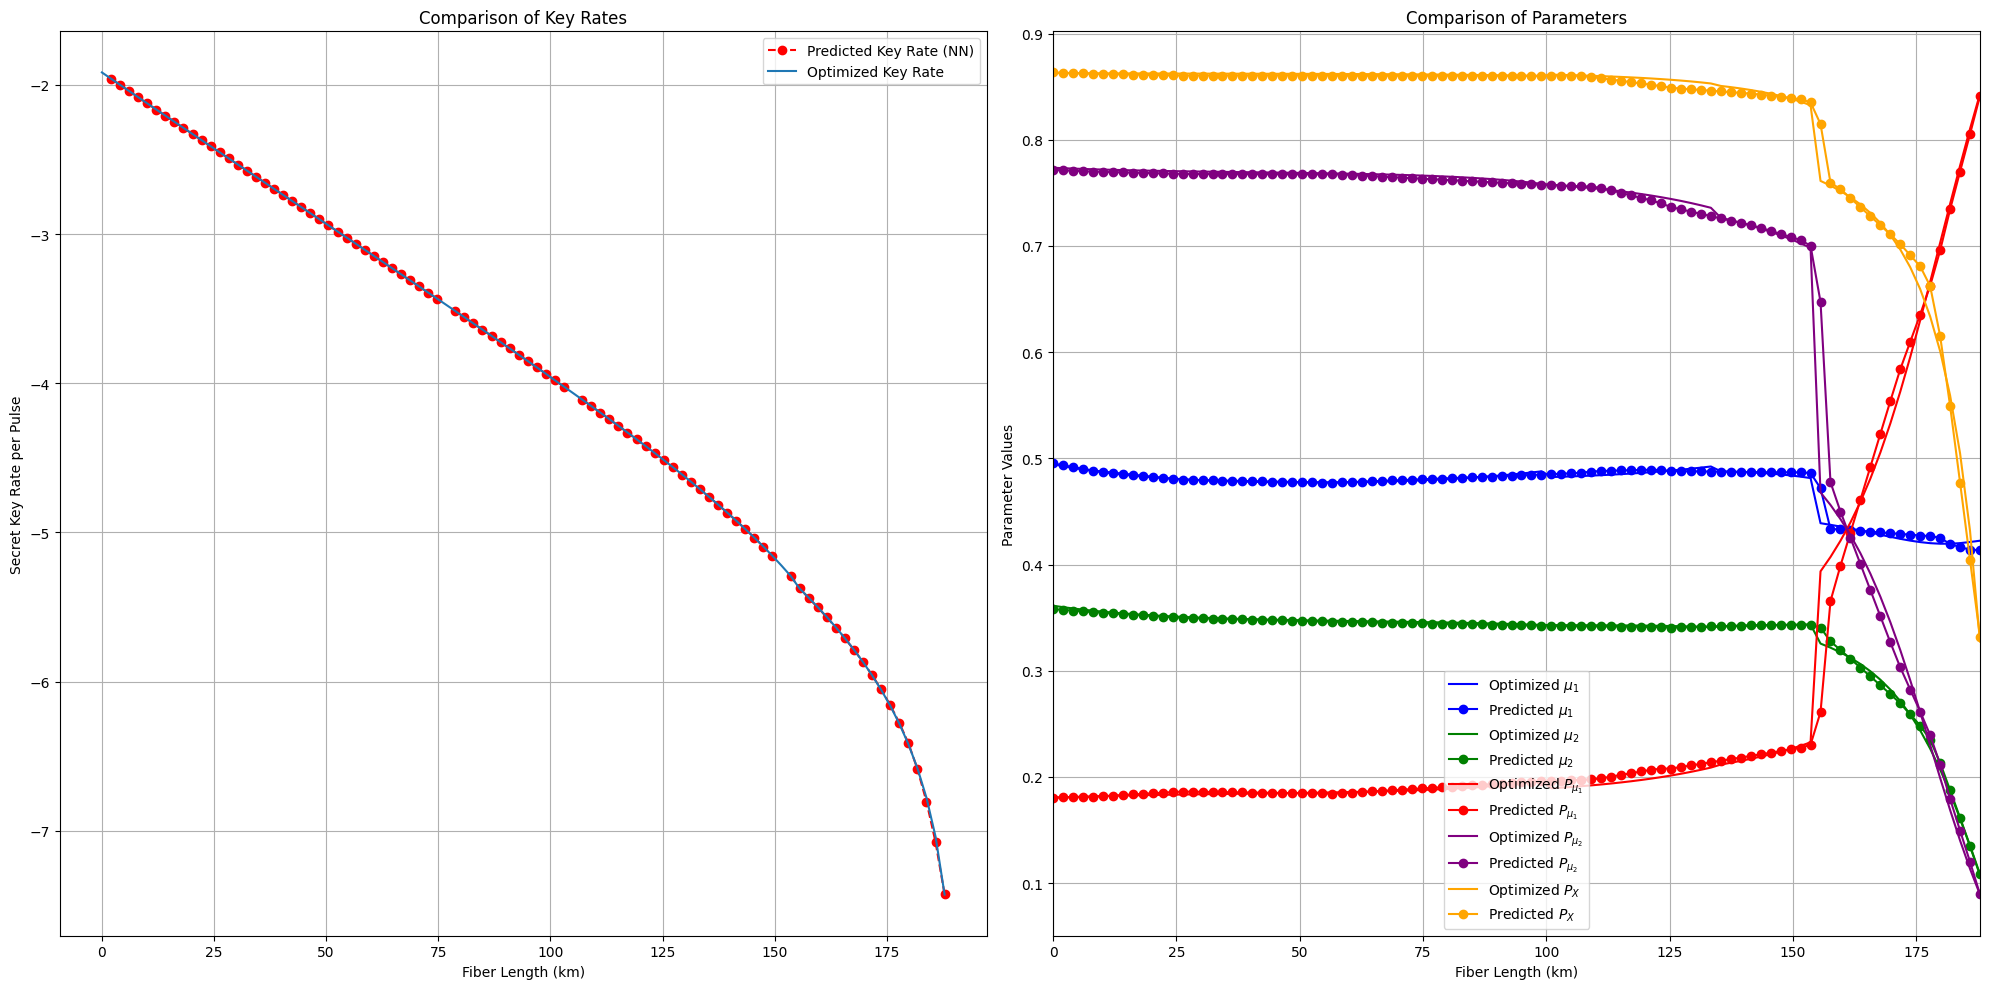

Plot saved to keyrate_parameters_last_epoch.png


In [13]:

    # Plotting for the last epoch
model.eval()
with torch.no_grad():
    # Load the best model (if early stopping was used)
    # model.load_state_dict(torch.load('best_bb84nn_model.pth'))

        # Make predictions
        X_test_tensor = X_test_tensor.to(device)
        predicted_params_scaled = model(X_test_tensor).cpu().numpy()
        predicted_params = y_scaler.inverse_transform(predicted_params_scaled)  # Inverse transform

        # Compute key rates using the predicted parameters
        predicted_key_rates = []
        for params, L in zip(predicted_params, fiber_lengths):
            key_rate = objective(params, L, target_nx, alpha=0.2, eta_Bob=0.1, P_dc_value=6e-7, epsilon_sec=1e-10, epsilon_cor=1e-15, f_EC=1.16, e_mis=5e-3, P_ap=0, n_event=1)[0]
            predicted_key_rates.append(key_rate)
        predicted_key_rates = np.array(predicted_key_rates)

        # Plot key rate and parameters for the last epoch
        plot_keyrate_and_parameters(fiber_lengths, optimized_key_rates, optimized_params_array,
                                    predicted_key_rates, predicted_params, num_epochs - 1, 'keyrate_parameters_last_epoch.png', learning_rates)

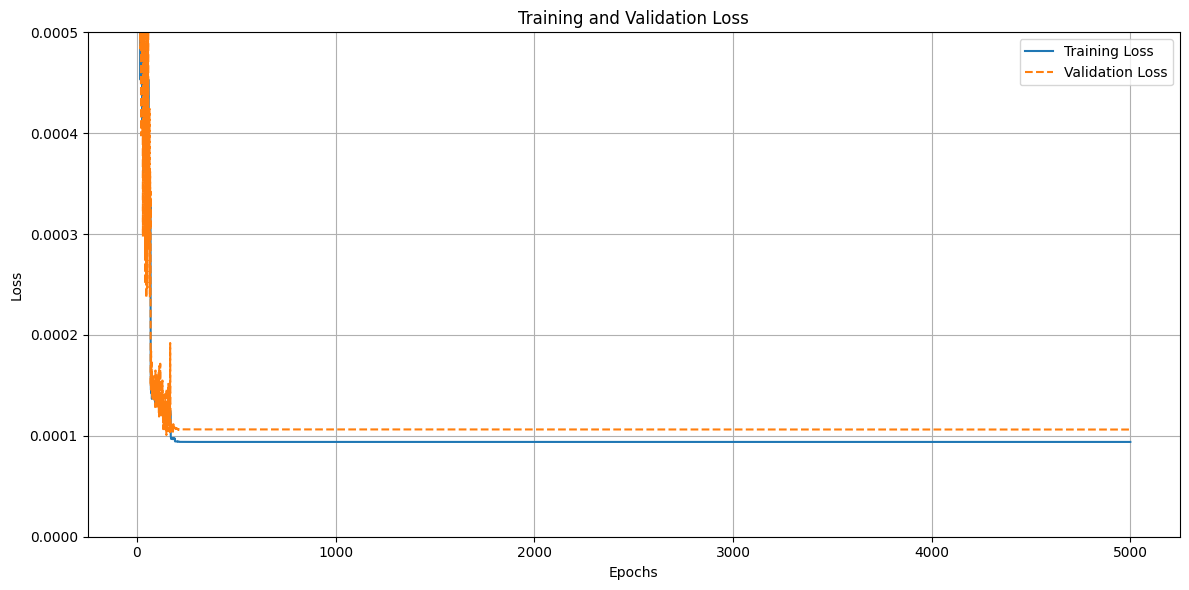

Training Complete


In [14]:
# Plotting the losses
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_losses, label='Training Loss', linestyle='-')
plt.plot(epochs, val_losses, label='Validation Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 0.0005)
plt.legend()
plt.title('Training and Validation Loss')
plt.grid(True)
plt.tight_layout()
plt.savefig('loss_plot.png')
plt.show()

print("Training Complete")

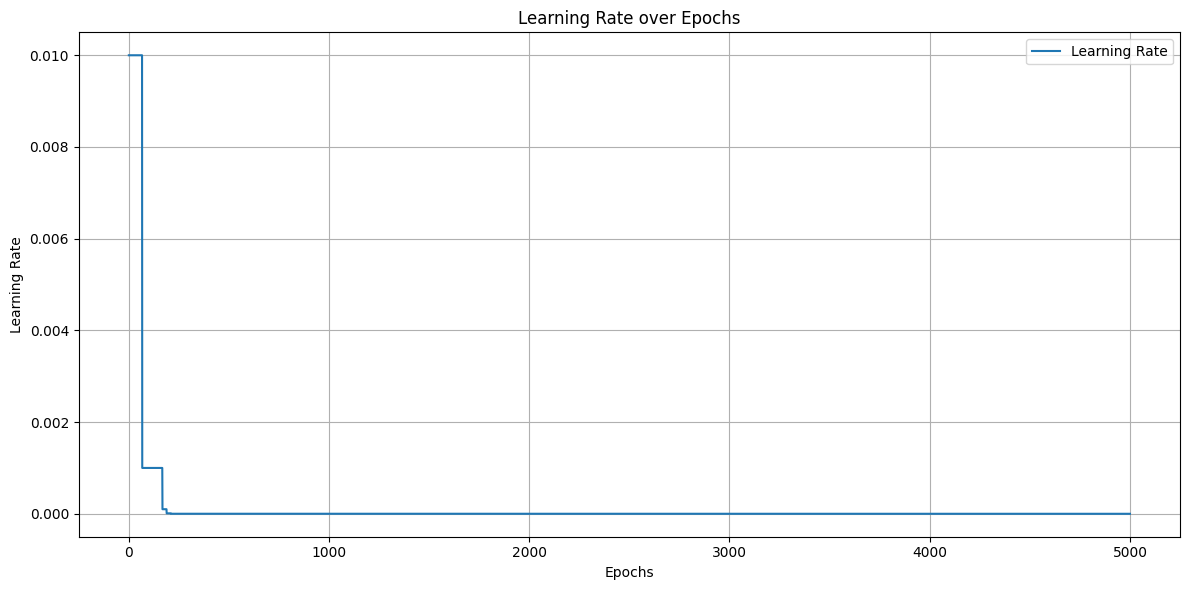

In [15]:
# Plotting the learning rates
plt.figure(figsize=(12, 6))
plt.plot(epochs, learning_rates, label='Learning Rate', linestyle='-', color='tab:blue')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
# plt.yscale('log')  # Use logarithmic scale for better visualization
plt.legend()
plt.title('Learning Rate over Epochs')
plt.grid(True)
plt.tight_layout()
plt.savefig('learning_rate_plot.png')
plt.show()

In [16]:
# # %% [markdown]
# # ### Generate Plots for All n_X Values (10^4 to 10^9) at the Last Epoch

# # Define the range of n_X values to evaluate
# nx_values = [10**s for s in range(4, 10)]  # 10^4 to 10^9

# # Dictionary to store evaluation data for each n_X
# all_evaluation_data = {}

# # Load evaluation datasets for each n_X
# for nx in nx_values:
#     nx_key = str(float(nx))
#     try:
#         with open(f"../n_X/good/{nx_key}_100_reordered_qkd_grouped_dataset_20250226_191349.json", 'r') as f:
#             evaluation_dataset = json.load(f)
#         if nx_key not in evaluation_dataset:
#             raise ValueError(f"No data found for n_X = {nx}")
#         all_evaluation_data[nx] = evaluation_dataset[nx_key]
#     except FileNotFoundError:
#         print(f"Evaluation dataset for n_X = {nx} not found. Skipping...")
#         continue

# # Generate plots for each n_X
# model.eval()
# for nx, evaluation_data in all_evaluation_data.items():
#     # Extract fiber lengths and optimized parameters
#     fiber_lengths = np.array([entry["fiber_length"] for entry in evaluation_data])
#     optimized_params_array = np.array([list(entry["optimized_params"].values()) for entry in evaluation_data])

#     # Compute optimized key rates
#     optimized_key_rates = []
#     for params, L in zip(optimized_params_array, fiber_lengths):
#         key_rate = objective(params, L, nx, alpha=0.2, eta_Bob=0.1, P_dc_value=6e-7, epsilon_sec=1e-10, epsilon_cor=1e-15, f_EC=1.16, e_mis=5e-3, P_ap=0, n_event=1)[0]
#         optimized_key_rates.append(key_rate)
#     optimized_key_rates = np.array(optimized_key_rates)

#     # Prepare test inputs for evaluation
#     X_test = []
#     for L in fiber_lengths:
#         e_1 = L / 100
#         e_2 = -np.log10(6e-7)
#         e_3 = 5e-3 * 100
#         e_4 = np.log10(nx)
#         X_test.append([e_1, e_2, e_3, e_4])
#     X_test = np.array(X_test)
#     X_test_scaled = scaler.transform(X_test)
#     X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)

#     # Make predictions
#     with torch.no_grad():
#         predicted_params_scaled = model(X_test_tensor).cpu().numpy()
#         predicted_params = y_scaler.inverse_transform(predicted_params_scaled)

#         # Compute predicted key rates
#         predicted_key_rates = []
#         for params, L in zip(predicted_params, fiber_lengths):
#             key_rate = objective(params, L, nx, alpha=0.2, eta_Bob=0.1, P_dc_value=6e-7, epsilon_sec=1e-10, epsilon_cor=1e-15, f_EC=1.16, e_mis=5e-3, P_ap=0, n_event=1)[0]
#             predicted_key_rates.append(key_rate)
#         predicted_key_rates = np.array(predicted_key_rates)

#     # Plot key rate and parameters
#     plot_keyrate_and_parameters(
#         fiber_lengths, optimized_key_rates, optimized_params_array,
#         predicted_key_rates, predicted_params, num_epochs - 1,
#         f'keyrate_parameters_nx_{int(nx)}_last_epoch.png', learning_rates
#     )

Loaded combined dataset with 6 n_X entries.
Extracted 736 entries for n_X = 10000.
Extracted 855 entries for n_X = 100000.
Extracted 902 entries for n_X = 1000000.
Extracted 927 entries for n_X = 10000000.
Extracted 942 entries for n_X = 100000000.
Extracted 948 entries for n_X = 1000000000.
No data found for n_X = 10000000000 in the combined dataset. Skipping...
Epoch 4999: Predicted Key Rates: [ 4.97792218e-004  4.92983400e-004  4.88222434e-004  4.83508377e-004
  4.78841395e-004  4.74220584e-004  4.69645077e-004  4.65115212e-004
 -1.00000000e+250 -1.00000000e+250]
Epoch 4999: Optimized Key Rates: [0.00049533 0.00049057 0.00048585 0.00048118 0.00047656 0.00047199
 0.00046746 0.00046297 0.00045853 0.00045413]


/var/folders/8m/0wg1hssn6n79tjc8mh6p_spr0000gn/T/ipykernel_87229/2488028585.py:30: RuntimeWarning: invalid value encountered in log10
  ax1.plot(fiber_lengths_key, np.log10(predicted_key_rates), 'r--', marker='o', label="Predicted Key Rate (NN)")


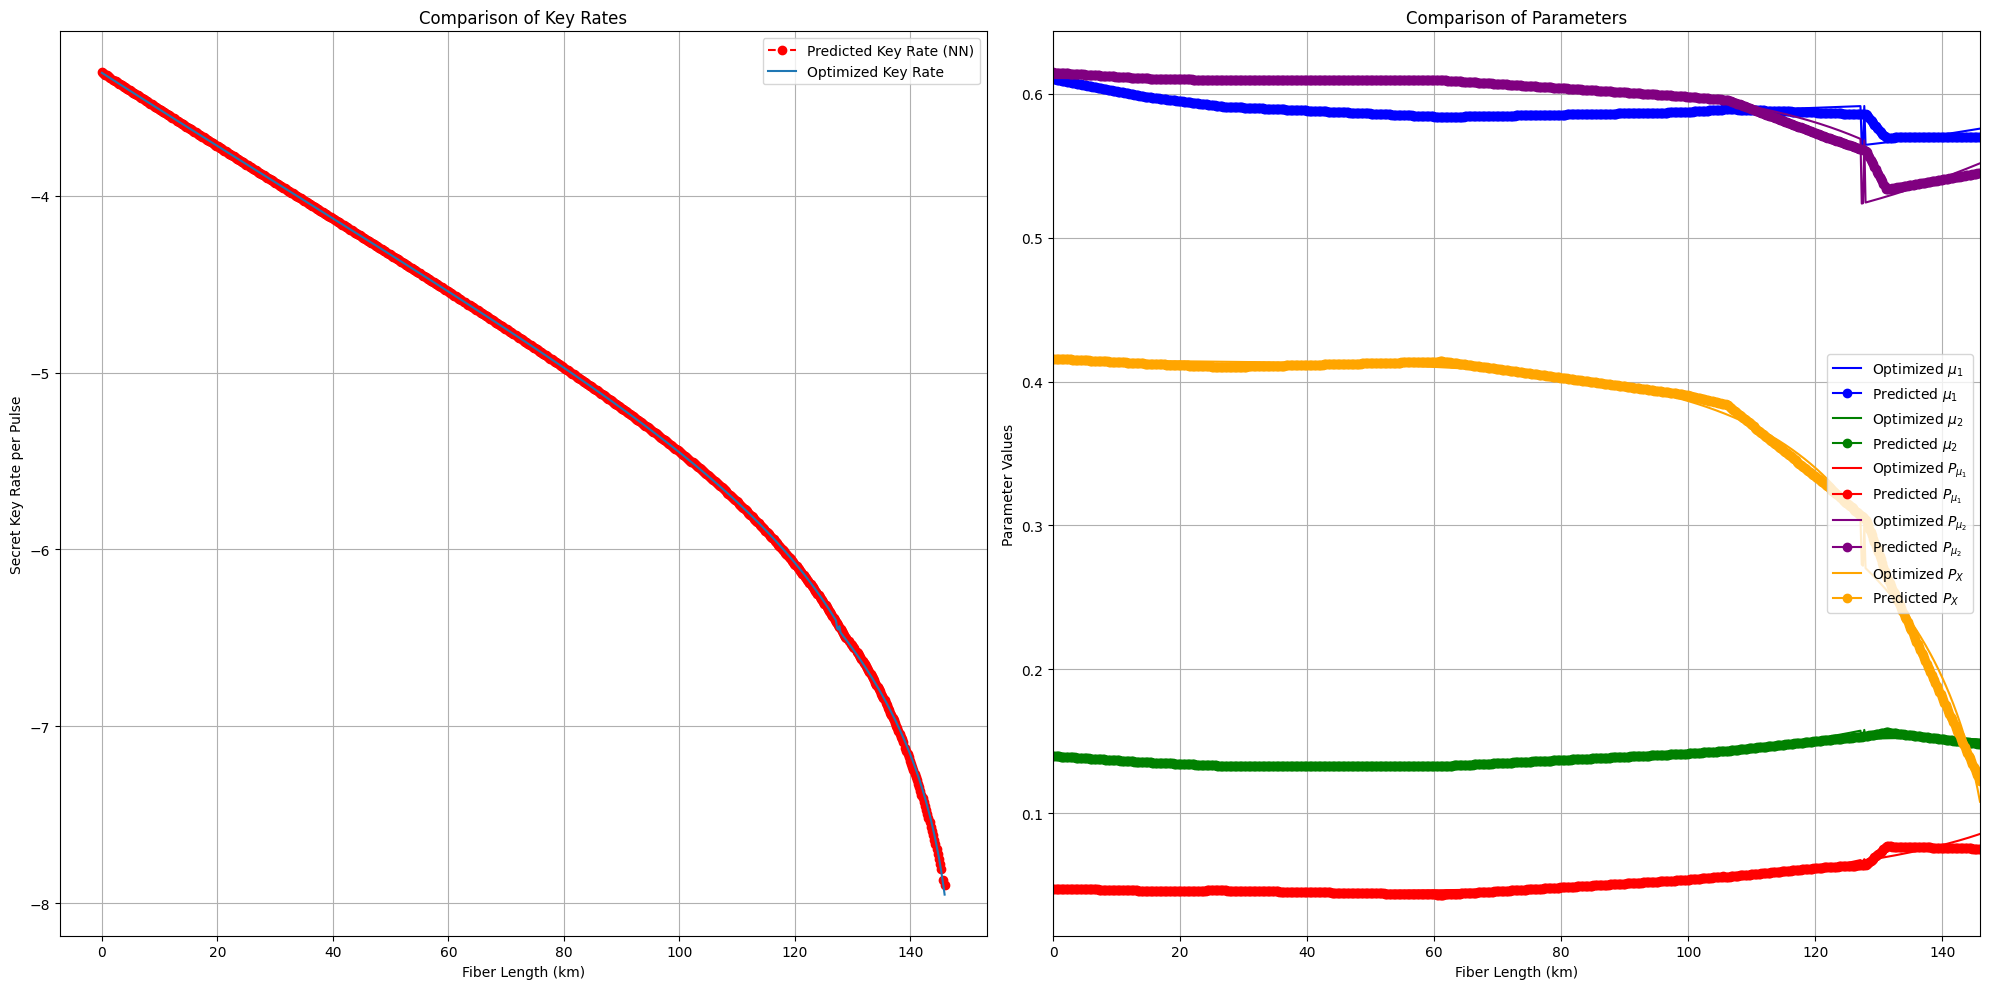

Plot saved to keyrate_parameters_nx_10000_last_epoch.png
Epoch 4999: Predicted Key Rates: [0.00202942 0.00200995 0.00199068 0.00197159 0.00195268 0.00193396
 0.00191543 0.00189708 0.0018789  0.00186091]
Epoch 4999: Optimized Key Rates: [0.00202592 0.00200657 0.0019874  0.00196842 0.00194964 0.00193103
 0.00191261 0.00189438 0.00187632 0.00185844]


/var/folders/8m/0wg1hssn6n79tjc8mh6p_spr0000gn/T/ipykernel_87229/2488028585.py:30: RuntimeWarning: invalid value encountered in log10
  ax1.plot(fiber_lengths_key, np.log10(predicted_key_rates), 'r--', marker='o', label="Predicted Key Rate (NN)")


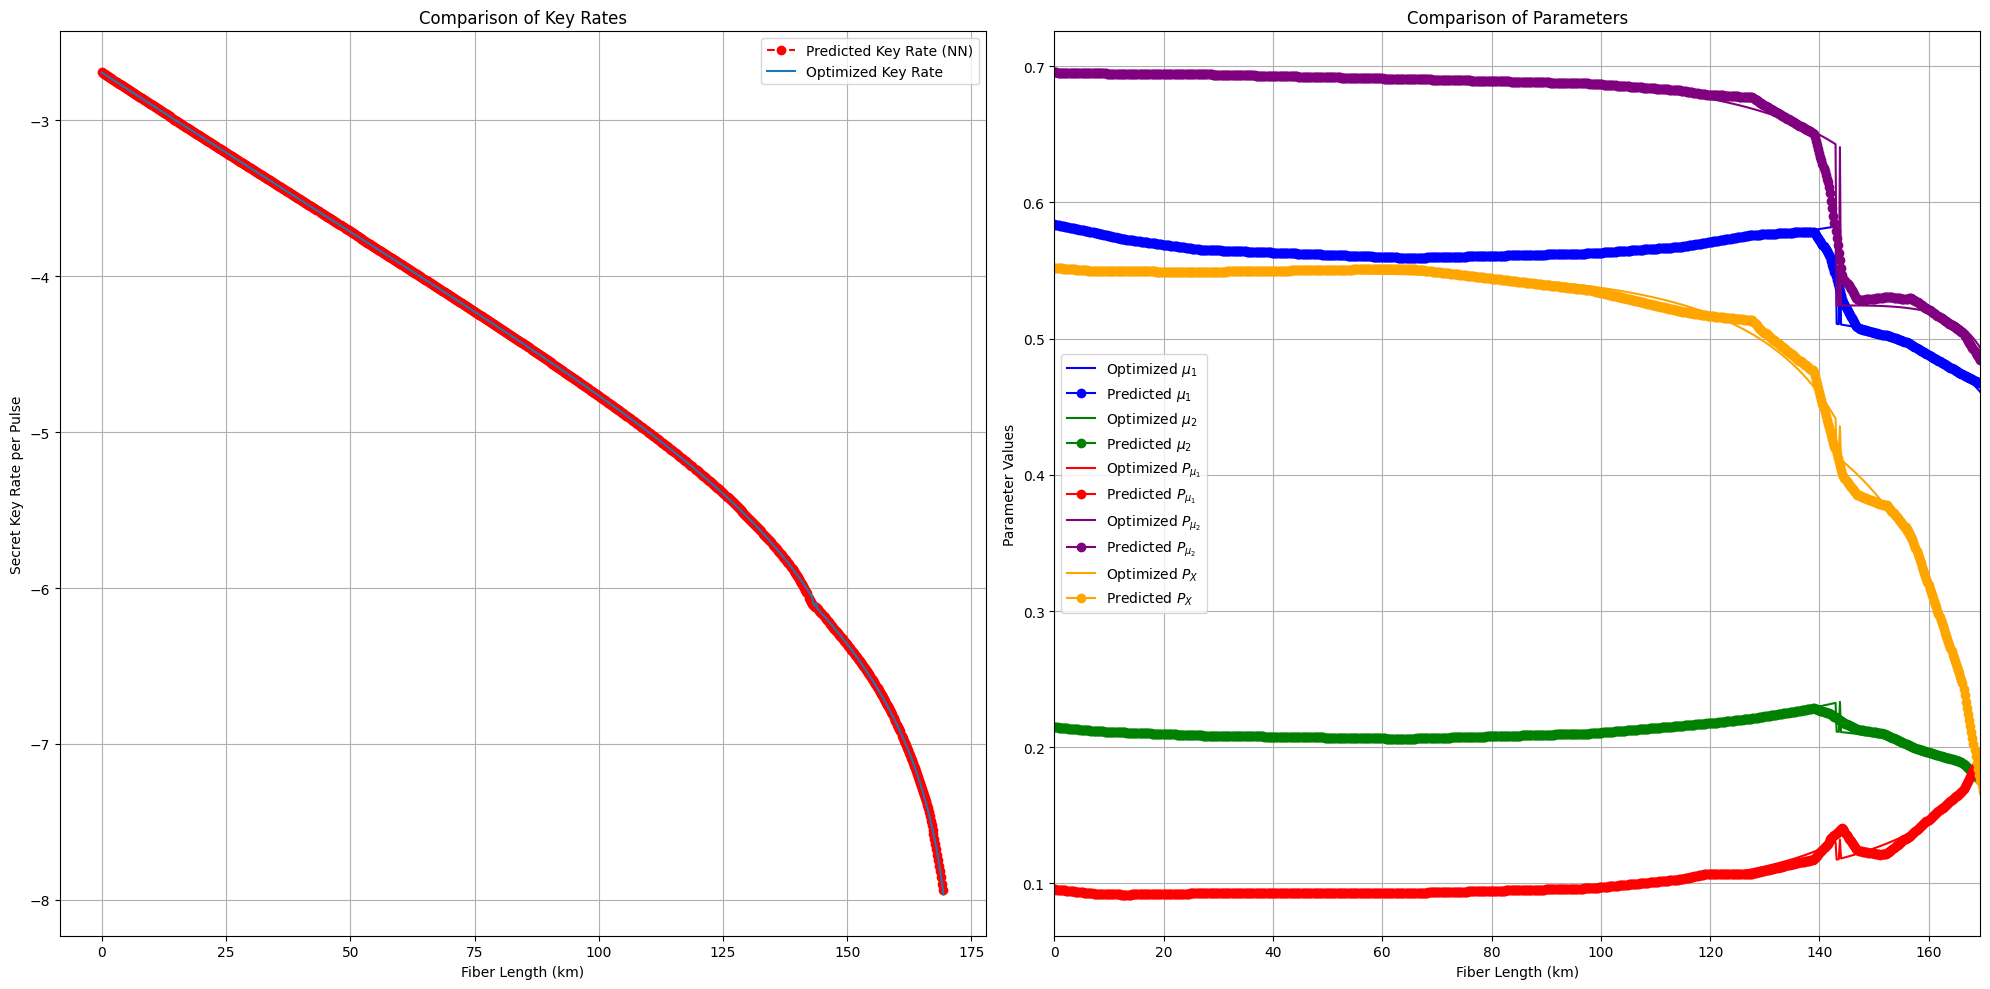

Plot saved to keyrate_parameters_nx_100000_last_epoch.png
Epoch 4999: Predicted Key Rates: [0.00445217 0.00440985 0.00436794 0.00432644 0.00428534 0.00424464
 0.00420434 0.00416443 0.00412491 0.00408577]
Epoch 4999: Optimized Key Rates: [0.00444778 0.00440544 0.00436352 0.004322   0.0042809  0.0042402
 0.0041999  0.00416    0.00412048 0.00408136]


/var/folders/8m/0wg1hssn6n79tjc8mh6p_spr0000gn/T/ipykernel_87229/2488028585.py:30: RuntimeWarning: invalid value encountered in log10
  ax1.plot(fiber_lengths_key, np.log10(predicted_key_rates), 'r--', marker='o', label="Predicted Key Rate (NN)")


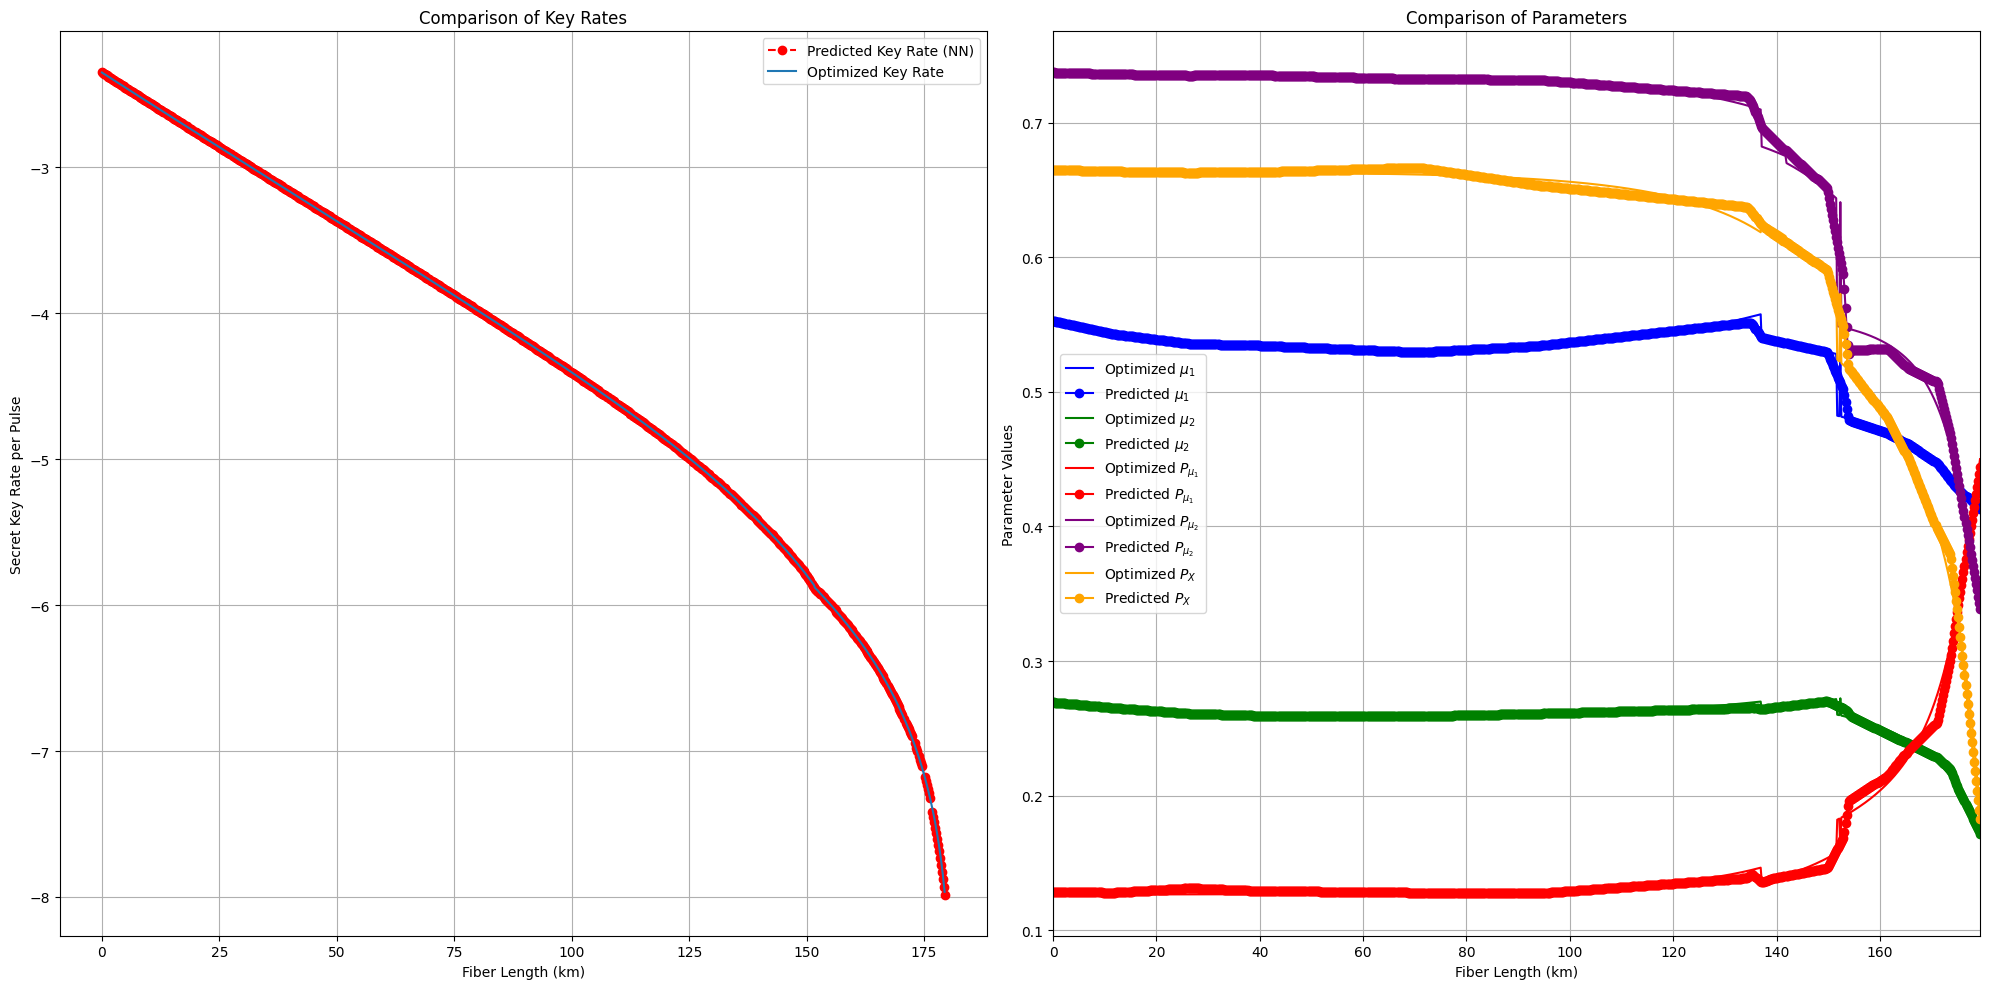

Plot saved to keyrate_parameters_nx_1000000_last_epoch.png
Epoch 4999: Predicted Key Rates: [ 7.34478950e-003  7.27514755e-003  7.20618251e-003  7.13788470e-003
  7.07025307e-003  7.00327517e-003  6.93694414e-003  6.87126398e-003
  6.80621407e-003 -1.00000000e+250]
Epoch 4999: Optimized Key Rates: [0.00735338 0.00728357 0.00721444 0.00714598 0.0070782  0.00701107
 0.00694461 0.00687879 0.00681361 0.00674907]


/var/folders/8m/0wg1hssn6n79tjc8mh6p_spr0000gn/T/ipykernel_87229/2488028585.py:30: RuntimeWarning: invalid value encountered in log10
  ax1.plot(fiber_lengths_key, np.log10(predicted_key_rates), 'r--', marker='o', label="Predicted Key Rate (NN)")


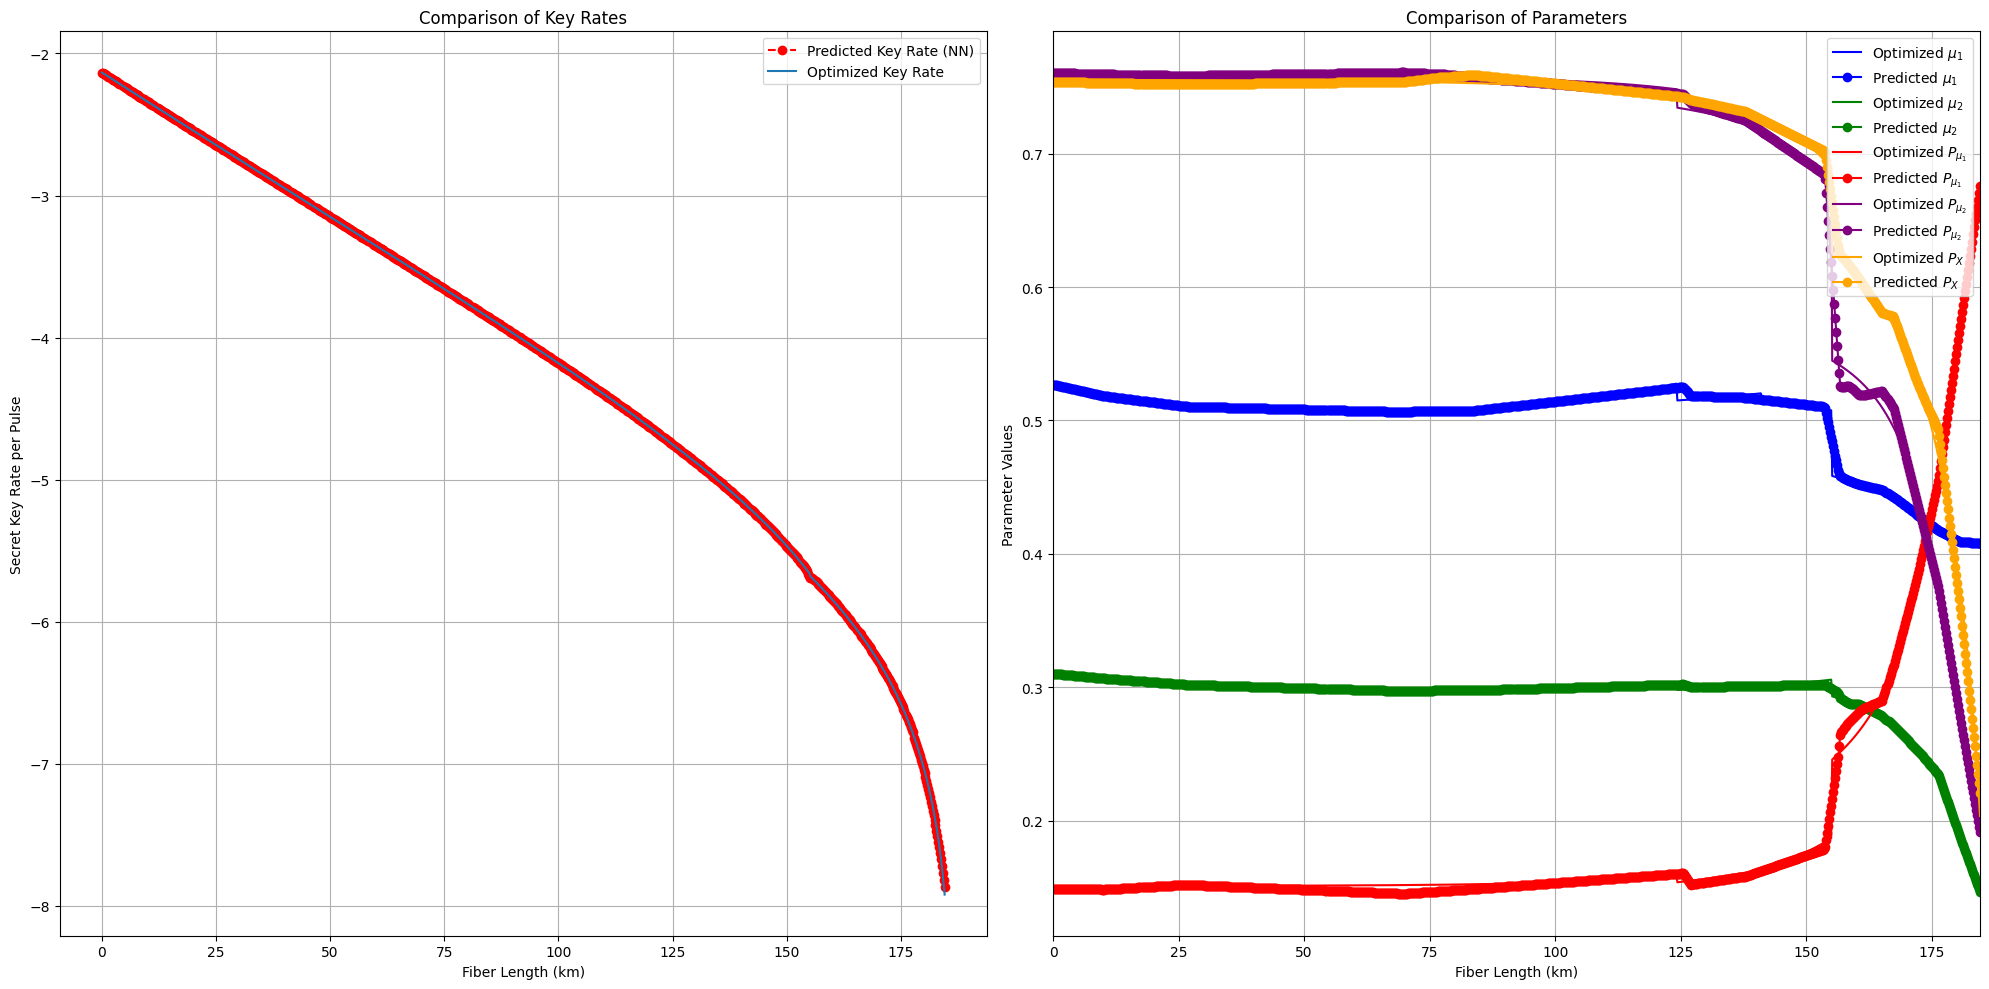

Plot saved to keyrate_parameters_nx_10000000_last_epoch.png
Epoch 4999: Predicted Key Rates: [0.01026388 0.01016675 0.01007059 0.00997533 0.00988101 0.00978759
 0.00969508 0.00960346 0.00951273 0.00942287]
Epoch 4999: Optimized Key Rates: [0.01026612 0.01016884 0.0100725  0.00997711 0.00988264 0.00978909
 0.00969645 0.00960472 0.00951387 0.00942391]


/var/folders/8m/0wg1hssn6n79tjc8mh6p_spr0000gn/T/ipykernel_87229/2488028585.py:30: RuntimeWarning: invalid value encountered in log10
  ax1.plot(fiber_lengths_key, np.log10(predicted_key_rates), 'r--', marker='o', label="Predicted Key Rate (NN)")


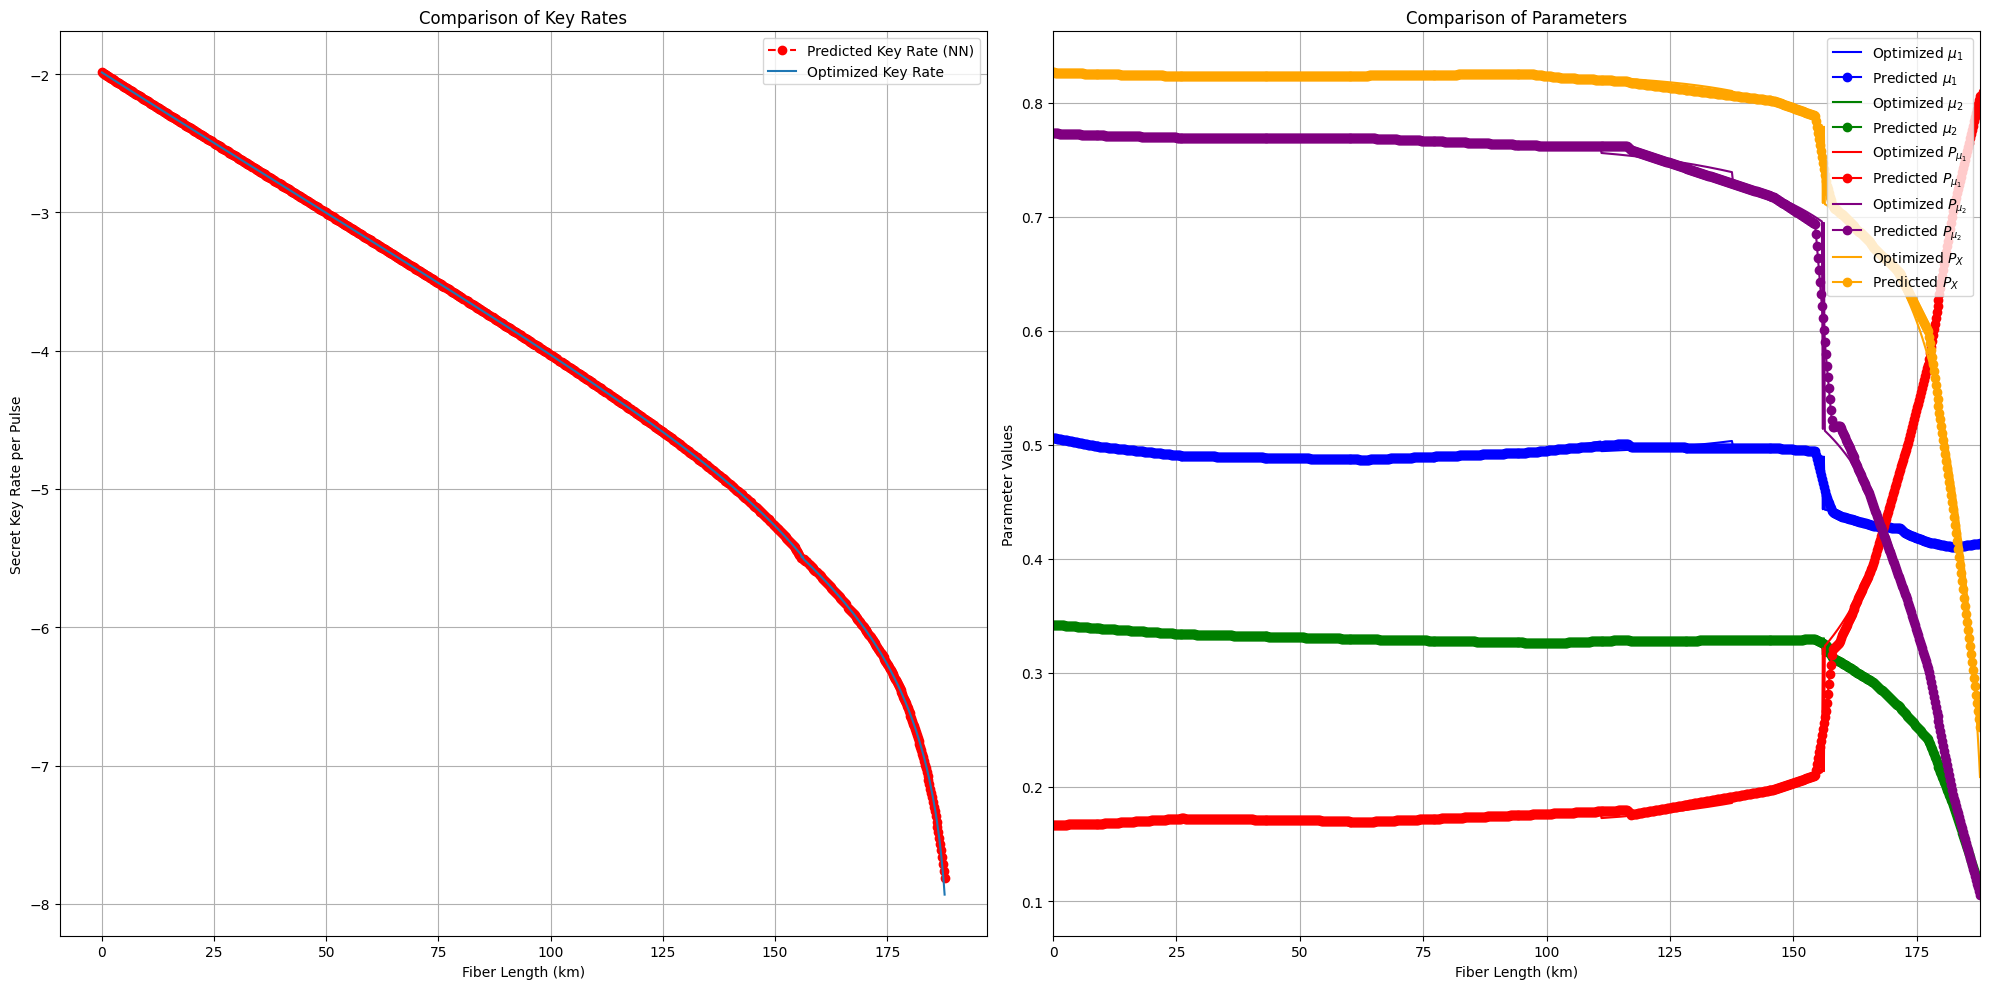

Plot saved to keyrate_parameters_nx_100000000_last_epoch.png
Epoch 4999: Predicted Key Rates: [0.01284068 0.01271937 0.01259926 0.01248029 0.01236246 0.01224576
 0.01213021 0.01201575 0.01190241 0.01179016]
Epoch 4999: Optimized Key Rates: [0.01285404 0.0127324  0.01261194 0.01249265 0.01237452 0.01225753
 0.01214168 0.01202696 0.01191335 0.01180084]


/var/folders/8m/0wg1hssn6n79tjc8mh6p_spr0000gn/T/ipykernel_87229/2488028585.py:30: RuntimeWarning: invalid value encountered in log10
  ax1.plot(fiber_lengths_key, np.log10(predicted_key_rates), 'r--', marker='o', label="Predicted Key Rate (NN)")


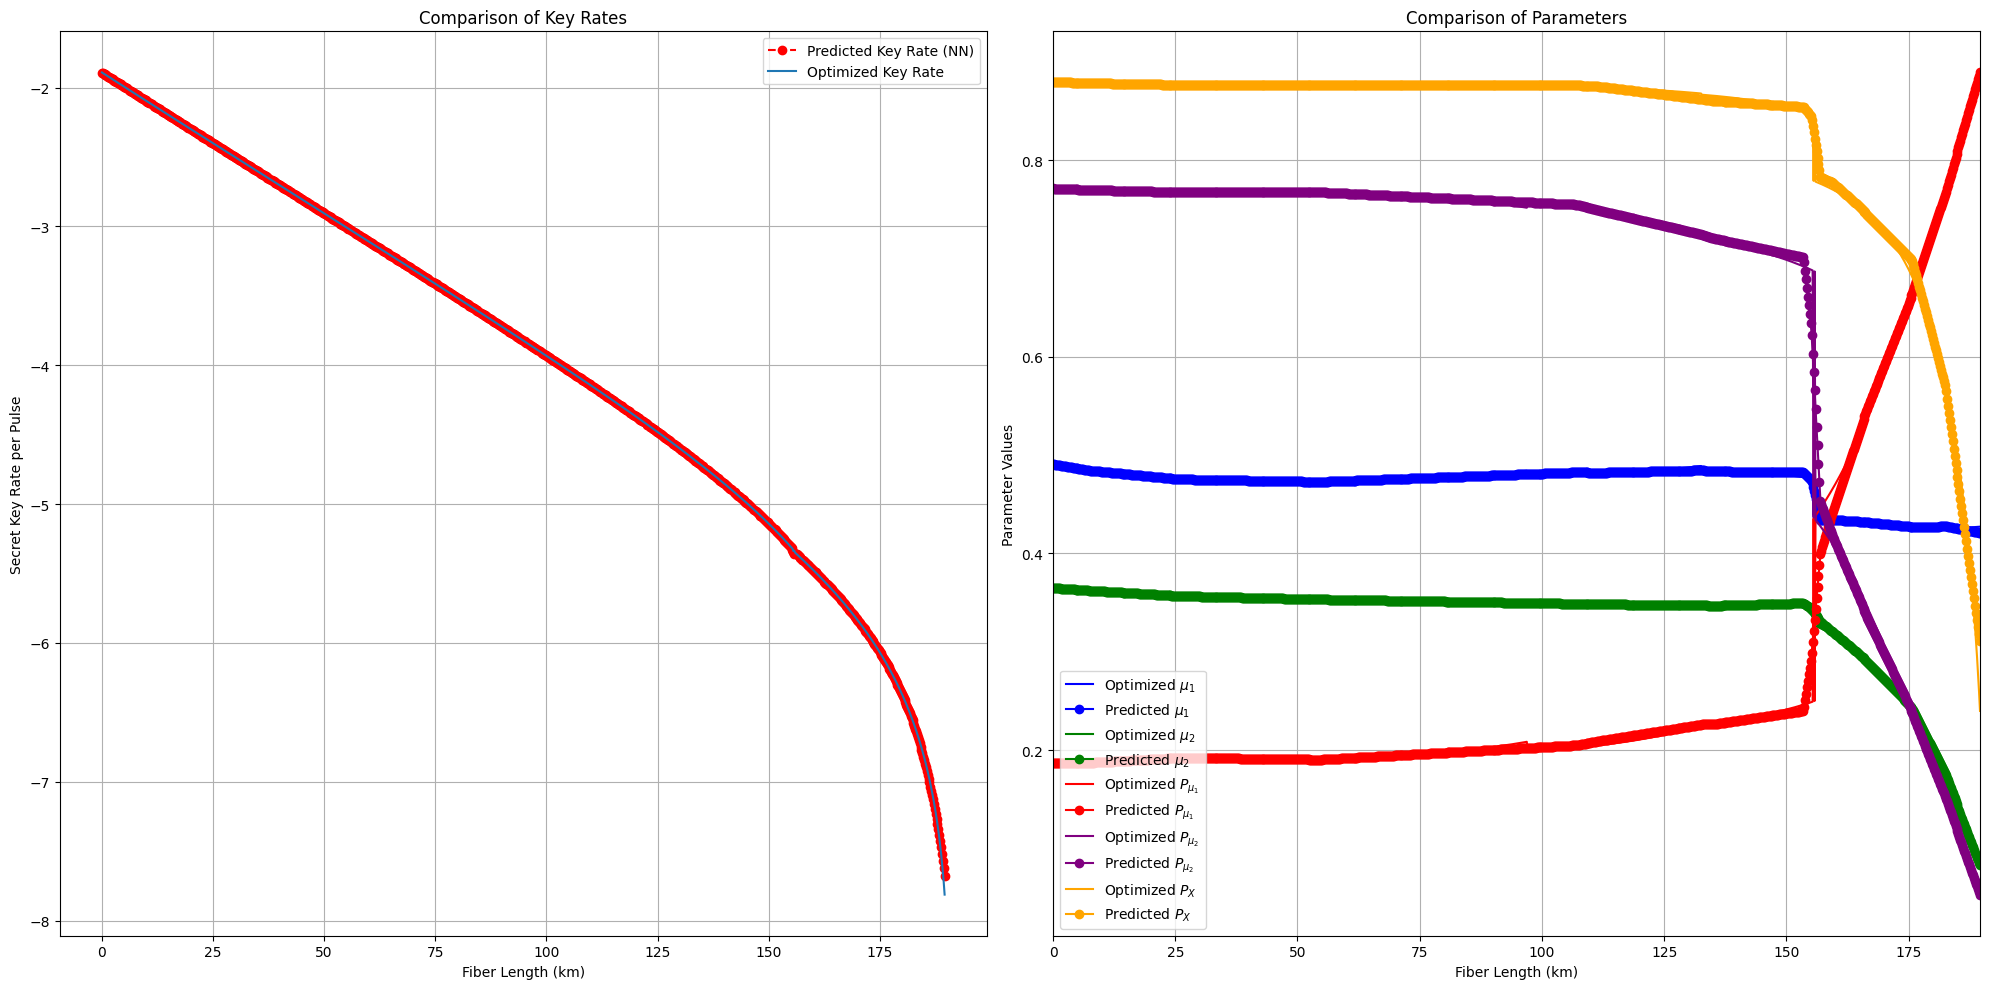

Plot saved to keyrate_parameters_nx_1000000000_last_epoch.png


In [17]:
# %% [markdown]
# ### Generate Plots for All n_X Values (10^4 to 10^10) at the Last Epoch Using Combined Dataset

# Load the combined dataset
combined_file_path = '../Training_Data/n_X/good/cleaned_combined_datasets.json'  # Adjust path if needed
try:
    with open(combined_file_path, 'r') as f:
        combined_data = json.load(f)
    print(f"Loaded combined dataset with {len(combined_data)} n_X entries.")
except FileNotFoundError:
    raise FileNotFoundError(f"Combined dataset not found at {combined_file_path}.")

# Define the range of n_X values to evaluate
nx_values = [10**s for s in range(4, 11)]  # 10^4 to 10^10

# Dictionary to store evaluation data for each n_X
all_evaluation_data = {}

# Extract data for each n_X from the combined dataset
for nx in nx_values:
    nx_key = str(float(nx))  # e.g., "10000.0" for 10^4
    if nx_key not in combined_data:
        print(f"No data found for n_X = {nx} in the combined dataset. Skipping...")
        continue
    evaluation_data = combined_data[nx_key]
    all_evaluation_data[nx] = evaluation_data
    print(f"Extracted {len(evaluation_data)} entries for n_X = {nx}.")

# Generate plots for each n_X
model.eval()
for nx, evaluation_data in all_evaluation_data.items():
    # Extract fiber lengths and optimized parameters
    fiber_lengths = np.array([entry["fiber_length"] for entry in evaluation_data])
    optimized_params_array = np.array([list(entry["optimized_params"].values()) for entry in evaluation_data])

    # Compute optimized key rates
    optimized_key_rates = []
    for params, L in zip(optimized_params_array, fiber_lengths):
        key_rate = objective(params, L, nx, alpha=0.2, eta_Bob=0.1, P_dc_value=6e-7, epsilon_sec=1e-10, epsilon_cor=1e-15, f_EC=1.16, e_mis=5e-3, P_ap=0, n_event=1)[0]
        optimized_key_rates.append(key_rate)
    optimized_key_rates = np.array(optimized_key_rates)

    # Prepare test inputs for evaluation
    X_test = []
    for L in fiber_lengths:
        e_1 = L / 100
        e_2 = -np.log10(6e-7)
        e_3 = 5e-3 * 100
        e_4 = np.log10(nx)
        X_test.append([e_1, e_2, e_3, e_4])
    X_test = np.array(X_test)
    X_test_scaled = scaler.transform(X_test)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)

    # Make predictions
    with torch.no_grad():
        predicted_params_scaled = model(X_test_tensor).cpu().numpy()
        predicted_params = y_scaler.inverse_transform(predicted_params_scaled)

        # Compute predicted key rates
        predicted_key_rates = []
        for params, L in zip(predicted_params, fiber_lengths):
            key_rate = objective(params, L, nx, alpha=0.2, eta_Bob=0.1, P_dc_value=6e-7, epsilon_sec=1e-10, epsilon_cor=1e-15, f_EC=1.16, e_mis=5e-3, P_ap=0, n_event=1)[0]
            predicted_key_rates.append(key_rate)
        predicted_key_rates = np.array(predicted_key_rates)

    # Plot key rate and parameters
    plot_keyrate_and_parameters(
        fiber_lengths, optimized_key_rates, optimized_params_array,
        predicted_key_rates, predicted_params, num_epochs - 1,
        f'keyrate_parameters_nx_{int(nx)}_last_epoch.png', learning_rates
    )

In [18]:
# # %% [markdown]
# # Import necessary libraries
# import torch
# import torch.nn as nn
# from torch.utils.data import DataLoader, TensorDataset, Subset
# import torch.optim as optim
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split, KFold
# from sklearn.preprocessing import StandardScaler, MinMaxScaler
# from sklearn.metrics import mean_absolute_error
# import json
# from tqdm import tqdm
# import torch.nn.functional as F
# import joblib
# import os
# import sys
# from torch.utils.data import DataLoader, random_split

# # Get the notebook's directory
# notebook_dir = os.getcwd()
# # Add parent directory to path
# project_root = os.path.dirname(notebook_dir)
# sys.path.append(project_root)

# # %% [markdown]
# # Checking if the MPS (Metal Performance Shaders) backend is available

# # %%
# # Check if MPS is available
# if not torch.backends.mps.is_available():
#     raise RuntimeError("MPS device not available. Check if PyTorch and macOS set up correctly.")

# # Set the device to MPS
# device = torch.device("mps")  # Use GPU on M2 Pro

# # %%
# # Import the objective function
# from QKD_Functions.QKD_Functions import (
#     calculate_factorial, calculate_tau_n, calculate_eta_ch, calculate_eta_sys,
#     calculate_D_mu_k, calculate_n_X_total, calculate_N, calculate_n_Z_total,
#     calculate_e_mu_k, calculate_e_obs, calculate_h, calculate_lambda_EC,
#     calculate_sqrt_term, calculate_n_pm, calculate_S_0, calculate_S_1,
#     calculate_m_mu_k, calculate_m_pm, calculate_v_1, calculate_gamma,
#     calculate_Phi, calculate_LastTwoTerm, calculate_l, calculate_R,
#     experimental_parameters, other_parameters, calculate_key_rates_and_metrics,
#     penalty, objective,
# )

# # %%
# # Load dataset
# with open('../Training_Data/n_X/good/cleaned_combined_datasets.json', 'r') as f:
#     data_by_nx = json.load(f)

# print(f"The overall dataset contains {len(data_by_nx)} entries.")

# # Verify the length of the list associated with the first key
# first_key = list(data_by_nx.keys())[0]
# print(f"The number of entries associated with the first key ({first_key}) is: {len(data_by_nx[first_key])}")

# # Flatten the data structure and filter
# cleaned_data = []
# for n_x, entries in data_by_nx.items():
#     cleaned_data.extend([
#         item for item in entries
#         if item["key_rate"] > 0 and item["e_1"] * 100 <= 200
#     ])

# # Optional: Verify the cleaned dataset
# if not cleaned_data:
#     print("No valid data after filtering.")
# else:
#     print(f"Filtered dataset contains {len(cleaned_data)} entries.")
#     print("\nSample entry from the cleaned dataset:")
#     print(json.dumps(cleaned_data[0], indent=2))
#     print("\nNumber of unique n_X values:", len(data_by_nx))

# # %%
# X = np.array([[item['e_1'], item['e_2'], item['e_3'], item['e_4']] for item in cleaned_data])
# Y = np.array([[item['optimized_params']['mu_1'], item['optimized_params']['mu_2'], item['optimized_params']['P_mu_1'], item['optimized_params']['P_mu_2'], item['optimized_params']['P_X_value']] for item in cleaned_data])

# from sklearn.utils import shuffle

# X, Y = shuffle(X, Y, random_state=42)

# scaler = StandardScaler()
# X = scaler.fit_transform(X)  # Fit and transform on training data

# y_scaler = MinMaxScaler()  # Scale targets to [0, 1]
# Y = y_scaler.fit_transform(Y)

# # Save the scalers
# joblib.dump(scaler, 'scaler.pkl')  # Save StandardScaler
# joblib.dump(y_scaler, 'y_scaler.pkl')  # Save MinMaxScaler

# print(f"X shape: {X.shape}, Y shape: {Y.shape}")
# dataset = TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32))

# # %%
# # Split dataset into train and validation sets
# train_size = int(0.8 * len(dataset))  # 80% for training
# val_size = len(dataset) - train_size  # 20% for validation

# train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# # Data loaders
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# # %%
# # Load evaluation data for n_X = 5e8
# with open("../n_X/good/5e8_100_reordered_qkd_grouped_dataset_20250226_191349.json", 'r') as f:
#     evaluation_dataset = json.load(f)

# # Select target n_X for evaluation
# target_nx = 5 * 100000000  # 5e8
# nx_key = str(float(target_nx))
# if nx_key not in evaluation_dataset:
#     raise ValueError(f"No data found for n_X = {target_nx}")
# evaluation_data = evaluation_dataset[nx_key]

# # Extract evaluation fiber lengths and optimized parameters
# fiber_lengths_5e8 = np.array([entry["fiber_length"] for entry in evaluation_data])
# optimized_params_array_5e8 = np.array([list(entry["optimized_params"].values()) for entry in evaluation_data])

# # Compute optimized key rates for evaluation
# optimized_key_rates_5e8 = []
# for params, L in zip(optimized_params_array_5e8, fiber_lengths_5e8):
#     key_rate = objective(params, L, target_nx, alpha=0.2, eta_Bob=0.1, P_dc_value=6e-7, epsilon_sec=1e-10, epsilon_cor=1e-15, f_EC=1.16, e_mis=5e-3, P_ap=0, n_event=1)[0]
#     optimized_key_rates_5e8.append(key_rate)
# optimized_key_rates_5e8 = np.array(optimized_key_rates_5e8)

# # Prepare test inputs for evaluation (n_X = 5e8)
# X_test_5e8 = []
# for L in fiber_lengths_5e8:
#     e_1 = L / 100
#     e_2 = -np.log10(6e-7)
#     e_3 = 5e-3 * 100
#     e_4 = np.log10(target_nx)
#     X_test_5e8.append([e_1, e_2, e_3, e_4])

# X_test_5e8 = np.array(X_test_5e8)
# X_test_scaled_5e8 = scaler.transform(X_test_5e8)  # Use the same scaler fitted on training data
# X_test_tensor_5e8 = torch.tensor(X_test_scaled_5e8, dtype=torch.float32).to(device)

# # %% [markdown]
# # ### Prepare Evaluation Data for All n_X Values (10^4 to 10^10) Before Training

# # Load the combined dataset
# combined_file_path = '../Training_Data/n_X/good/cleaned_combined_datasets.json'
# try:
#     with open(combined_file_path, 'r') as f:
#         combined_data = json.load(f)
#     print(f"Loaded combined dataset with {len(combined_data)} n_X entries.")
# except FileNotFoundError:
#     raise FileNotFoundError(f"Combined dataset not found at {combined_file_path}.")

# # Define the range of n_X values to evaluate
# nx_values = [10**s for s in range(4, 11)]  # 10^4 to 10^10

# # Dictionary to store evaluation data for each n_X
# all_evaluation_data = {}

# # Extract and prepare evaluation data for each n_X
# for nx in nx_values:
#     nx_key = str(float(nx))  # e.g., "10000.0" for 10^4
#     if nx_key not in combined_data:
#         print(f"No data found for n_X = {nx} in the combined dataset. Skipping...")
#         continue
#     evaluation_data = combined_data[nx_key]
#     print(f"Extracted {len(evaluation_data)} entries for n_X = {nx}.")

#     # Extract fiber lengths and optimized parameters
#     fiber_lengths = np.array([entry["fiber_length"] for entry in evaluation_data])
#     optimized_params_array = np.array([list(entry["optimized_params"].values()) for entry in evaluation_data])

#     # Compute optimized key rates
#     optimized_key_rates = []
#     for params, L in zip(optimized_params_array, fiber_lengths):
#         key_rate = objective(params, L, nx, alpha=0.2, eta_Bob=0.1, P_dc_value=6e-7, epsilon_sec=1e-10, epsilon_cor=1e-15, f_EC=1.16, e_mis=5e-3, P_ap=0, n_event=1)[0]
#         optimized_key_rates.append(key_rate)
#     optimized_key_rates = np.array(optimized_key_rates)

#     # Prepare test inputs for evaluation
#     X_test = []
#     for L in fiber_lengths:
#         e_1 = L / 100
#         e_2 = -np.log10(6e-7)
#         e_3 = 5e-3 * 100
#         e_4 = np.log10(nx)
#         X_test.append([e_1, e_2, e_3, e_4])
#     X_test = np.array(X_test)
#     X_test_scaled = scaler.transform(X_test)
#     X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)

#     # Store all evaluation data in a dictionary
#     all_evaluation_data[nx] = {
#         'fiber_lengths': fiber_lengths,
#         'optimized_params_array': optimized_params_array,
#         'optimized_key_rates': optimized_key_rates,
#         'X_test_tensor': X_test_tensor
#     }

# # %%
# # Define the neural network model
# class BB84NN(nn.Module):
#     def __init__(self):
#         super(BB84NN, self).__init__()
#         self.fc1 = nn.Linear(4, 16)
#         self.fc2 = nn.Linear(16, 32)
#         self.fc3 = nn.Linear(32, 16)
#         self.fc4 = nn.Linear(16, 5)

#     def forward(self, x):
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = F.relu(self.fc3(x))
#         x = self.fc4(x)
#         return x

# # Initialize model, loss, optimizer, and scheduler
# model = BB84NN().to(device)
# criterion = nn.MSELoss()  # Mean Squared Error for regression
# optimizer = optim.Adam(model.parameters(), lr=1e-2)  # Adam optimizer
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=20)

# # Lists to store metrics
# train_losses = []
# val_losses = []
# learning_rates = []

# # Function to create and save key rate and parameters plot
# def plot_keyrate_and_parameters(fiber_lengths, optimized_key_rates, optimized_params_array,
#                                 predicted_key_rates, predicted_params_array, epoch, filename, learning_rates, nx):
#     """Plots key rate and parameter comparison and saves the figure."""
#     # Debug: Print key rates to diagnose the issue
#     print(f"Epoch {epoch}: Predicted Key Rates: {predicted_key_rates[:10]}")  # Print first 10 values
#     print(f"Epoch {epoch}: Optimized Key Rates: {optimized_key_rates[:10]}")  # Print first 10 values

#     # Find the index where the optimized key rate becomes non-positive (or very small)
#     threshold = 1e-8  # Practical threshold based on previous plots
#     cutoff_idx = np.where(optimized_key_rates <= threshold)[0]
#     if len(cutoff_idx) > 0:
#         cutoff_idx = cutoff_idx[0]  # Take the first index where key rate <= threshold
#     else:
#         cutoff_idx = len(fiber_lengths)  # If no non-positive key rates, use the full length

#     # Truncate data for the key rates plot (left panel)
#     fiber_lengths_key = fiber_lengths[:cutoff_idx]
#     optimized_key_rates = optimized_key_rates[:cutoff_idx]
#     predicted_key_rates = predicted_key_rates[:cutoff_idx]

#     # Truncate data for the parameters plot (right panel) to match the key rates
#     fiber_lengths_params = fiber_lengths[:cutoff_idx]
#     optimized_params_array = optimized_params_array[:cutoff_idx]
#     predicted_params_array = predicted_params_array[:cutoff_idx]

#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    
#     # Add a main title to the figure
#     plt.suptitle(f'BB84 Protocol: $n_X = {nx:.1e}$, Epoch {epoch}', fontsize=16, y=1.05)

#     # Plot key rates (left panel)
#     if predicted_key_rates is not None and len(predicted_key_rates) > 0:
#         ax1.plot(fiber_lengths_key, np.log10(predicted_key_rates), 'r--', marker='o', label="Predicted Key Rate (NN)")
#     ax1.plot(fiber_lengths_key, np.log10(optimized_key_rates), label='Optimized Key Rate')
#     ax1.set_title('Comparison of Key Rates')
#     ax1.set_xlabel('Fiber Length (km)')
#     ax1.set_ylabel('Secret Key Rate per Pulse')
#     ax1.legend()
#     ax1.grid(True)

#     # Plot parameters (right panel)
#     labels = ['$\mu_1$', '$\mu_2$', '$P_{\mu_1}$', '$P_{\mu_2}$', '$P_X$']
#     colors = ['blue', 'green', 'red', 'purple', 'orange']
#     for i in range(5):
#         ax2.plot(fiber_lengths_params, optimized_params_array[:, i], label=f'Optimized {labels[i]}', color=colors[i], linestyle='-')
#         ax2.plot(fiber_lengths_params, predicted_params_array[:, i], label=f'Predicted {labels[i]}', marker='o', color=colors[i], linestyle='-')
#     ax2.set_title('Comparison of Parameters')
#     ax2.set_xlabel('Fiber Length (km)')
#     ax2.set_ylabel('Parameter Values')
#     ax2.set_xlim([0, fiber_lengths_params[-1] if len(fiber_lengths_params) > 0 else 200])  # Dynamically set x-axis limit
#     ax2.legend()
#     ax2.grid(True)

#     plt.tight_layout()
#     plt.savefig(filename)
#     plt.show()
#     print(f"Plot saved to {filename}")

# # Training loop
# num_epochs = 5000
# for epoch in range(num_epochs):
#     # Training phase
#     model.train()
#     running_loss = 0.0
#     for inputs, targets in train_loader:
#         inputs, targets = inputs.to(device), targets.to(device)
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, targets)
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item() * inputs.size(0)
#     epoch_loss = running_loss / len(train_loader.dataset)
#     train_losses.append(epoch_loss)

#     # Validation phase
#     model.eval()
#     val_running_loss = 0.0
#     with torch.no_grad():
#         for inputs, targets in val_loader:
#             inputs, targets = inputs.to(device), targets.to(device)
#             outputs = model(inputs)
#             loss = criterion(outputs, targets)
#             val_running_loss += loss.item() * inputs.size(0)
#     val_loss = val_running_loss / len(val_loader.dataset)
#     val_losses.append(val_loss)

#     # Update learning rate
#     scheduler.step(val_loss)
#     current_lr = optimizer.param_groups[0]['lr']
#     learning_rates.append(current_lr)

#     # Print epoch results
#     print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}")

#     # Evaluate and plot at the first and last epochs
#     model.eval()
#     with torch.no_grad():
#         # First, evaluate for all n_X values (10^4 to 10^10)
#         for nx, eval_data in all_evaluation_data.items():
#             fiber_lengths = eval_data['fiber_lengths']
#             optimized_params_array = eval_data['optimized_params_array']
#             optimized_key_rates = eval_data['optimized_key_rates']
#             X_test_tensor = eval_data['X_test_tensor']

#             predicted_params_scaled = model(X_test_tensor).cpu().numpy()
#             predicted_params = y_scaler.inverse_transform(predicted_params_scaled)
#             predicted_key_rates = []
#             for params, L in zip(predicted_params, fiber_lengths):
#                 key_rate = objective(params, L, nx, alpha=0.2, eta_Bob=0.1, P_dc_value=6e-7, epsilon_sec=1e-10, epsilon_cor=1e-15, f_EC=1.16, e_mis=5e-3, P_ap=0, n_event=1)[0]
#                 predicted_key_rates.append(key_rate)
#             predicted_key_rates = np.array(predicted_key_rates)

#             # Plot at the first and last epochs
#             if epoch == 0:
#                 plot_keyrate_and_parameters(
#                     fiber_lengths, optimized_key_rates, optimized_params_array,
#                     predicted_key_rates, predicted_params, epoch,
#                     f'keyrate_parameters_nx_{int(nx)}_first_epoch.png', learning_rates, nx=nx
#                 )
#             if epoch == num_epochs - 1:
#                 plot_keyrate_and_parameters(
#                     fiber_lengths, optimized_key_rates, optimized_params_array,
#                     predicted_key_rates, predicted_params, epoch,
#                     f'keyrate_parameters_nx_{int(nx)}_last_epoch.png', learning_rates, nx=nx
#                 )

#         # Then, evaluate for n_X = 5e8 (unseen data) after all other n_X values
#         if epoch == 0 or epoch == num_epochs - 1:
#             predicted_params_scaled_5e8 = model(X_test_tensor_5e8).cpu().numpy()
#             predicted_params_5e8 = y_scaler.inverse_transform(predicted_params_scaled_5e8)
#             predicted_key_rates_5e8 = []
#             for params, L in zip(predicted_params_5e8, fiber_lengths_5e8):
#                 key_rate = objective(params, L, target_nx, alpha=0.2, eta_Bob=0.1, P_dc_value=6e-7, epsilon_sec=1e-10, epsilon_cor=1e-15, f_EC=1.16, e_mis=5e-3, P_ap=0, n_event=1)[0]
#                 predicted_key_rates_5e8.append(key_rate)
#             predicted_key_rates_5e8 = np.array(predicted_key_rates_5e8)

#             if epoch == 0:
#                 plot_keyrate_and_parameters(
#                     fiber_lengths_5e8, optimized_key_rates_5e8, optimized_params_array_5e8,
#                     predicted_key_rates_5e8, predicted_params_5e8, epoch,
#                     'keyrate_parameters_5e8_first_epoch.png', learning_rates, nx=target_nx
#                 )
#             if epoch == num_epochs - 1:
#                 plot_keyrate_and_parameters(
#                     fiber_lengths_5e8, optimized_key_rates_5e8, optimized_params_array_5e8,
#                     predicted_key_rates_5e8, predicted_params_5e8, epoch,
#                     'keyrate_parameters_5e8_last_epoch.png', learning_rates, nx=target_nx
#                 )
                
# # Plotting the losses
# epochs = range(1, len(train_losses) + 1)

# plt.figure(figsize=(12, 6))
# plt.plot(epochs, train_losses, label='Training Loss', linestyle='-')
# plt.plot(epochs, val_losses, label='Validation Loss', linestyle='--')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.ylim(0, 0.0005)
# plt.legend()
# plt.title('Training and Validation Loss')
# plt.grid(True)
# plt.tight_layout()
# plt.savefig('loss_plot.png')
# plt.show()

# print("Training Complete")

# # %%
# # Plotting the learning rates
# plt.figure(figsize=(12, 6))
# plt.plot(epochs, learning_rates, label='Learning Rate', linestyle='-', color='tab:blue')
# plt.xlabel('Epochs')
# plt.ylabel('Learning Rate')
# plt.legend()
# plt.title('Learning Rate over Epochs')
# plt.grid(True)
# plt.tight_layout()
# plt.savefig('learning_rate_plot.png')
# plt.show()

In [19]:
# %% [markdown]
# Import necessary libraries
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, Subset
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error
import json
from tqdm import tqdm
import torch.nn.functional as F
import joblib
import os
import sys
from torch.utils.data import DataLoader, random_split
import time  # For timing

# Set matplotlib to use a non-interactive backend
plt.switch_backend('Agg')

# Get the notebook's directory
notebook_dir = os.getcwd()
# Add parent directory to path
project_root = os.path.dirname(notebook_dir)
sys.path.append(project_root)

# %% [markdown]
# Checking if the MPS (Metal Performance Shaders) backend is available

# %%
# Check if MPS is available
if not torch.backends.mps.is_available():
    raise RuntimeError("MPS device not available. Check if PyTorch and macOS set up correctly.")

# Set the device to MPS
device = torch.device("mps")  # Use GPU on M2 Pro

# %%
# Import the objective function
from QKD_Functions.QKD_Functions import (
    calculate_factorial, calculate_tau_n, calculate_eta_ch, calculate_eta_sys,
    calculate_D_mu_k, calculate_n_X_total, calculate_N, calculate_n_Z_total,
    calculate_e_mu_k, calculate_e_obs, calculate_h, calculate_lambda_EC,
    calculate_sqrt_term, calculate_n_pm, calculate_S_0, calculate_S_1,
    calculate_m_mu_k, calculate_m_pm, calculate_v_1, calculate_gamma,
    calculate_Phi, calculate_LastTwoTerm, calculate_l, calculate_R,
    experimental_parameters, other_parameters, calculate_key_rates_and_metrics,
    penalty, objective,
)

# %%
# Load dataset
with open('../Training_Data/n_X/good/cleaned_combined_datasets.json', 'r') as f:
    data_by_nx = json.load(f)

print(f"The overall dataset contains {len(data_by_nx)} entries.")

# Verify the length of the list associated with the first key
first_key = list(data_by_nx.keys())[0]
print(f"The number of entries associated with the first key ({first_key}) is: {len(data_by_nx[first_key])}")

# Flatten the data structure and filter
cleaned_data = []
for n_x, entries in data_by_nx.items():
    cleaned_data.extend([
        item for item in entries
        if item["key_rate"] > 0 and item["e_1"] * 100 <= 200
    ])

# Optional: Verify the cleaned dataset
if not cleaned_data:
    print("No valid data after filtering.")
else:
    print(f"Filtered dataset contains {len(cleaned_data)} entries.")
    print("\nSample entry from the cleaned dataset:")
    print(json.dumps(cleaned_data[0], indent=2))
    print("\nNumber of unique n_X values:", len(data_by_nx))

# %%
X = np.array([[item['e_1'], item['e_2'], item['e_3'], item['e_4']] for item in cleaned_data])
Y = np.array([[item['optimized_params']['mu_1'], item['optimized_params']['mu_2'], item['optimized_params']['P_mu_1'], item['optimized_params']['P_mu_2'], item['optimized_params']['P_X_value']] for item in cleaned_data])

from sklearn.utils import shuffle

X, Y = shuffle(X, Y, random_state=42)

scaler = StandardScaler()
X = scaler.fit_transform(X)  # Fit and transform on training data

y_scaler = MinMaxScaler()  # Scale targets to [0, 1]
Y = y_scaler.fit_transform(Y)

# Save the scalers
joblib.dump(scaler, 'scaler.pkl')  # Save StandardScaler
joblib.dump(y_scaler, 'y_scaler.pkl')  # Save MinMaxScaler

print(f"X shape: {X.shape}, Y shape: {Y.shape}")
dataset = TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32))

# %%
# Split dataset into train and validation sets
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size  # 20% for validation

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# %%
# Load evaluation data for n_X = 5e8
with open("../n_X/good/5e8_100_reordered_qkd_grouped_dataset_20250226_191349.json", 'r') as f:
    evaluation_dataset = json.load(f)

# Select target n_X for evaluation
target_nx = 5 * 100000000  # 5e8
nx_key = str(float(target_nx))
if nx_key not in evaluation_dataset:
    raise ValueError(f"No data found for n_X = {target_nx}")
evaluation_data = evaluation_dataset[nx_key]

# Extract evaluation fiber lengths and optimized parameters
fiber_lengths_5e8 = np.array([entry["fiber_length"] for entry in evaluation_data])
optimized_params_array_5e8 = np.array([list(entry["optimized_params"].values()) for entry in evaluation_data])

# Compute optimized key rates for evaluation
optimized_key_rates_5e8 = []
for params, L in zip(optimized_params_array_5e8, fiber_lengths_5e8):
    key_rate = objective(params, L, target_nx, alpha=0.2, eta_Bob=0.1, P_dc_value=6e-7, epsilon_sec=1e-10, epsilon_cor=1e-15, f_EC=1.16, e_mis=5e-3, P_ap=0, n_event=1)[0]
    optimized_key_rates_5e8.append(key_rate)
optimized_key_rates_5e8 = np.array(optimized_key_rates_5e8)

# Prepare test inputs for evaluation (n_X = 5e8)
X_test_5e8 = []
for L in fiber_lengths_5e8:
    e_1 = L / 100
    e_2 = -np.log10(6e-7)
    e_3 = 5e-3 * 100
    e_4 = np.log10(target_nx)
    X_test_5e8.append([e_1, e_2, e_3, e_4])

X_test_5e8 = np.array(X_test_5e8)
X_test_scaled_5e8 = scaler.transform(X_test_5e8)  # Use the same scaler fitted on training data
X_test_tensor_5e8 = torch.tensor(X_test_scaled_5e8, dtype=torch.float32).to(device)

# %% [markdown]
# ### Prepare Evaluation Data for All n_X Values (10^4 to 10^10) Before Training

# Load the combined dataset
combined_file_path = '../Training_Data/n_X/good/cleaned_combined_datasets.json'
try:
    with open(combined_file_path, 'r') as f:
        combined_data = json.load(f)
    print(f"Loaded combined dataset with {len(combined_data)} n_X entries.")
except FileNotFoundError:
    raise FileNotFoundError(f"Combined dataset not found at {combined_file_path}.")

# Define the range of n_X values to evaluate
nx_values = [10**s for s in range(4, 11)]  # 10^4 to 10^10

# Dictionary to store evaluation data for each n_X
all_evaluation_data = {}

# Extract and prepare evaluation data for each n_X
for nx in nx_values:
    nx_key = str(float(nx))  # e.g., "10000.0" for 10^4
    if nx_key not in combined_data:
        print(f"No data found for n_X = {nx} in the combined dataset. Skipping...")
        continue
    evaluation_data = combined_data[nx_key]
    print(f"Extracted {len(evaluation_data)} entries for n_X = {nx}.")

    # Extract fiber lengths and optimized parameters
    fiber_lengths = np.array([entry["fiber_length"] for entry in evaluation_data])
    optimized_params_array = np.array([list(entry["optimized_params"].values()) for entry in evaluation_data])

    # Compute optimized key rates
    optimized_key_rates = []
    for params, L in zip(optimized_params_array, fiber_lengths):
        key_rate = objective(params, L, nx, alpha=0.2, eta_Bob=0.1, P_dc_value=6e-7, epsilon_sec=1e-10, epsilon_cor=1e-15, f_EC=1.16, e_mis=5e-3, P_ap=0, n_event=1)[0]
        optimized_key_rates.append(key_rate)
    optimized_key_rates = np.array(optimized_key_rates)

    # Prepare test inputs for evaluation
    X_test = []
    for L in fiber_lengths:
        e_1 = L / 100
        e_2 = -np.log10(6e-7)
        e_3 = 5e-3 * 100
        e_4 = np.log10(nx)
        X_test.append([e_1, e_2, e_3, e_4])
    X_test = np.array(X_test)
    X_test_scaled = scaler.transform(X_test)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)

    # Store all evaluation data in a dictionary
    all_evaluation_data[nx] = {
        'fiber_lengths': fiber_lengths,
        'optimized_params_array': optimized_params_array,
        'optimized_key_rates': optimized_key_rates,
        'X_test_tensor': X_test_tensor
    }

# %%
# Define the neural network model
class BB84NN(nn.Module):
    def __init__(self):
        super(BB84NN, self).__init__()
        self.fc1 = nn.Linear(4, 16)
        self.fc2 = nn.Linear(16, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 5)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Initialize model, loss, optimizer, and scheduler
model = BB84NN().to(device)
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=1e-2)  # Adam optimizer
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=20)

# Lists to store metrics
train_losses = []
val_losses = []
learning_rates = []

def plot_keyrate_and_parameters(fiber_lengths, optimized_key_rates, optimized_params_array,
                                predicted_key_rates, predicted_params_array, epoch, filename, learning_rates, nx):
    """Plots key rate and parameter comparison and saves the figure."""
    # Debug: Print key rates to diagnose the issue
    print(f"Epoch {epoch}: Predicted Key Rates: {predicted_key_rates[:10]}")  # Print first 10 values
    print(f"Epoch {epoch}: Optimized Key Rates: {optimized_key_rates[:10]}")  # Print first 10 values

    # Find the index where the optimized key rate becomes non-positive (or very small)
    threshold = 1e-8  # Practical threshold based on previous plots
    cutoff_idx = np.where(optimized_key_rates <= threshold)[0]
    if len(cutoff_idx) > 0:
        cutoff_idx = cutoff_idx[0]  # Take the first index where key rate <= threshold
    else:
        cutoff_idx = len(fiber_lengths)  # If no non-positive key rates, use the full length

    # Truncate data for the key rates plot (left panel)
    fiber_lengths_key = fiber_lengths[:cutoff_idx]
    optimized_key_rates = optimized_key_rates[:cutoff_idx]
    predicted_key_rates = predicted_key_rates[:cutoff_idx]

    # Truncate data for the parameters plot (right panel) to match the key rates
    fiber_lengths_params = fiber_lengths[:cutoff_idx]
    optimized_params_array = optimized_params_array[:cutoff_idx]
    predicted_params_array = predicted_params_array[:cutoff_idx]

    # Create figure with increased height
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))  # Height increased to 8

    # Plot key rates (left panel)
    if predicted_key_rates is not None and len(predicted_key_rates) > 0:
        ax1.plot(fiber_lengths_key, np.log10(predicted_key_rates), 'r--', marker='o', label="Predicted Key Rate (NN)")
    ax1.plot(fiber_lengths_key, np.log10(optimized_key_rates), label='Optimized Key Rate')
    ax1.set_title(f'Comparison of Key Rates for $n_X = {nx:.1e}$, Epoch {epoch}', fontsize=10)
    ax1.set_xlabel('Fiber Length (km)')
    ax1.set_ylabel('Secret Key Rate per Pulse')
    ax1.legend()
    ax1.grid(True)

    # Plot parameters (right panel)
    labels = ['$\mu_1$', '$\mu_2$', '$P_{\mu_1}$', '$P_{\mu_2}$', '$P_X$']
    colors = ['blue', 'green', 'red', 'purple', 'orange']
    for i in range(5):
        ax2.plot(fiber_lengths_params, optimized_params_array[:, i], label=f'Optimized {labels[i]}', color=colors[i], linestyle='-')
        ax2.plot(fiber_lengths_params, predicted_params_array[:, i], label=f'Predicted {labels[i]}', marker='o', color=colors[i], linestyle='-')
    ax2.set_title(f'Comparison of Parameters for $n_X = {nx:.1e}$, Epoch {epoch}', fontsize=10)
    ax2.set_xlabel('Fiber Length (km)')
    ax2.set_ylabel('Parameter Values')
    ax2.set_xlim([0, fiber_lengths_params[-1] if len(fiber_lengths_params) > 0 else 200])  # Dynamically set x-axis limit
    ax2.legend()
    ax2.grid(True)

    # Add a main title to the figure
    plt.suptitle(f'BB84 Protocol: $n_X = {nx:.1e}$, Epoch {epoch}', fontsize=14, y=0.98)

    # Adjust layout to make space for the suptitle
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    # Save the figure with adjusted bounding box
    plt.savefig(filename, dpi=150, bbox_inches='tight')

    # Close the figure to free memory
    plt.close(fig)
    print(f"Plot saved to {filename}")

# %%
# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    start_time = time.time()  # Start timing the epoch

    # Training phase
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_running_loss += loss.item() * inputs.size(0)
    val_loss = val_running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)

    # Update learning rate
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)

    # Evaluate and plot at the first and last epochs
    eval_time = 0
    plot_time = 0
    if epoch == 0 or epoch == num_epochs - 1:
        model.eval()
        with torch.no_grad():
            # First, evaluate for all n_X values (10^4 to 10^10)
            for nx, eval_data in all_evaluation_data.items():
                eval_start = time.time()
                fiber_lengths = eval_data['fiber_lengths']
                optimized_params_array = eval_data['optimized_params_array']
                optimized_key_rates = eval_data['optimized_key_rates']
                X_test_tensor = eval_data['X_test_tensor']

                predicted_params_scaled = model(X_test_tensor).cpu().numpy()
                predicted_params = y_scaler.inverse_transform(predicted_params_scaled)
                predicted_key_rates = []
                for params, L in zip(predicted_params, fiber_lengths):
                    key_rate = objective(params, L, nx, alpha=0.2, eta_Bob=0.1, P_dc_value=6e-7, epsilon_sec=1e-10, epsilon_cor=1e-15, f_EC=1.16, e_mis=5e-3, P_ap=0, n_event=1)[0]
                    predicted_key_rates.append(key_rate)
                predicted_key_rates = np.array(predicted_key_rates)
                eval_time += time.time() - eval_start

                # Plot at the first and last epochs
                plot_start = time.time()
                if epoch == 0:
                    plot_keyrate_and_parameters(
                        fiber_lengths, optimized_key_rates, optimized_params_array,
                        predicted_key_rates, predicted_params, epoch,
                        f'keyrate_parameters_nx_{int(nx)}_first_epoch.png', learning_rates, nx=nx
                    )
                if epoch == num_epochs - 1:
                    plot_keyrate_and_parameters(
                        fiber_lengths, optimized_key_rates, optimized_params_array,
                        predicted_key_rates, predicted_params, epoch,
                        f'keyrate_parameters_nx_{int(nx)}_last_epoch.png', learning_rates, nx=nx
                    )
                plot_time += time.time() - plot_start

            # Then, evaluate for n_X = 5e8 (unseen data) after all other n_X values
            eval_start = time.time()
            predicted_params_scaled_5e8 = model(X_test_tensor_5e8).cpu().numpy()
            predicted_params_5e8 = y_scaler.inverse_transform(predicted_params_scaled_5e8)
            predicted_key_rates_5e8 = []
            for params, L in zip(predicted_params_5e8, fiber_lengths_5e8):
                key_rate = objective(params, L, target_nx, alpha=0.2, eta_Bob=0.1, P_dc_value=6e-7, epsilon_sec=1e-10, epsilon_cor=1e-15, f_EC=1.16, e_mis=5e-3, P_ap=0, n_event=1)[0]
                predicted_key_rates_5e8.append(key_rate)
            predicted_key_rates_5e8 = np.array(predicted_key_rates_5e8)
            eval_time += time.time() - eval_start

            plot_start = time.time()
            if epoch == 0:
                plot_keyrate_and_parameters(
                    fiber_lengths_5e8, optimized_key_rates_5e8, optimized_params_array_5e8,
                    predicted_key_rates_5e8, predicted_params_5e8, epoch,
                    'keyrate_parameters_5e8_first_epoch.png', learning_rates, nx=target_nx
                )
            if epoch == num_epochs - 1:
                plot_keyrate_and_parameters(
                    fiber_lengths_5e8, optimized_key_rates_5e8, optimized_params_array_5e8,
                    predicted_key_rates_5e8, predicted_params_5e8, epoch,
                    'keyrate_parameters_5e8_last_epoch.png', learning_rates, nx=target_nx
                )
            plot_time += time.time() - plot_start

    # Print epoch results with timing
    epoch_time = time.time() - start_time
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, "
          f"Time: {epoch_time:.2f}s (Eval: {eval_time:.2f}s, Plot: {plot_time:.2f}s)")



The overall dataset contains 6 entries.
The number of entries associated with the first key (10000.0) is: 736
Filtered dataset contains 5310 entries.

Sample entry from the cleaned dataset:
{
  "fiber_length": 0.0,
  "e_1": 0.0,
  "e_2": 6.221848749616356,
  "e_3": 0.5,
  "e_4": 4.0,
  "key_rate": 0.00037995895580899045,
  "optimized_params": {
    "mu_1": 0.6126301275287198,
    "mu_2": 0.13818683663411718,
    "P_mu_1": 0.04604299826386499,
    "P_mu_2": 0.6110117432731096,
    "P_X_value": 0.414731486913827
  }
}

Number of unique n_X values: 6
X shape: (5310, 4), Y shape: (5310, 5)
Loaded combined dataset with 6 n_X entries.
Extracted 736 entries for n_X = 10000.
Extracted 855 entries for n_X = 100000.
Extracted 902 entries for n_X = 1000000.
Extracted 927 entries for n_X = 10000000.
Extracted 942 entries for n_X = 100000000.
Extracted 948 entries for n_X = 1000000000.
No data found for n_X = 10000000000 in the combined dataset. Skipping...
Epoch 0: Predicted Key Rates: [0.00048965

/var/folders/8m/0wg1hssn6n79tjc8mh6p_spr0000gn/T/ipykernel_87229/1679668392.py:266: RuntimeWarning: invalid value encountered in log10
  ax1.plot(fiber_lengths_key, np.log10(predicted_key_rates), 'r--', marker='o', label="Predicted Key Rate (NN)")


Plot saved to keyrate_parameters_nx_10000_first_epoch.png
Epoch 0: Predicted Key Rates: [ 2.01633500e-003  1.99731021e-003  1.97847093e-003  1.95981199e-003
  1.94133424e-003  1.92303405e-003  1.90491005e-003  1.88696124e-003
 -1.00000000e+250  1.85158021e-003]
Epoch 0: Optimized Key Rates: [0.00202592 0.00200657 0.0019874  0.00196842 0.00194964 0.00193103
 0.00191261 0.00189438 0.00187632 0.00185844]


/var/folders/8m/0wg1hssn6n79tjc8mh6p_spr0000gn/T/ipykernel_87229/1679668392.py:266: RuntimeWarning: invalid value encountered in log10
  ax1.plot(fiber_lengths_key, np.log10(predicted_key_rates), 'r--', marker='o', label="Predicted Key Rate (NN)")


Plot saved to keyrate_parameters_nx_100000_first_epoch.png
Epoch 0: Predicted Key Rates: [0.00444592 0.00440395 0.00436238 0.00432121 0.00428044 0.00424006
 0.00420007 0.00416047 0.00412125 0.0040824 ]
Epoch 0: Optimized Key Rates: [0.00444778 0.00440544 0.00436352 0.004322   0.0042809  0.0042402
 0.0041999  0.00416    0.00412048 0.00408136]


/var/folders/8m/0wg1hssn6n79tjc8mh6p_spr0000gn/T/ipykernel_87229/1679668392.py:266: RuntimeWarning: invalid value encountered in log10
  ax1.plot(fiber_lengths_key, np.log10(predicted_key_rates), 'r--', marker='o', label="Predicted Key Rate (NN)")


Plot saved to keyrate_parameters_nx_1000000_first_epoch.png
Epoch 0: Predicted Key Rates: [ 7.32911610e-003  7.26036174e-003  7.19226538e-003  7.12482105e-003
  7.05801766e-003  6.99185055e-003  6.92630975e-003 -1.00000000e+250
  6.79710490e-003  6.73342648e-003]
Epoch 0: Optimized Key Rates: [0.00735338 0.00728357 0.00721444 0.00714598 0.0070782  0.00701107
 0.00694461 0.00687879 0.00681361 0.00674907]


/var/folders/8m/0wg1hssn6n79tjc8mh6p_spr0000gn/T/ipykernel_87229/1679668392.py:266: RuntimeWarning: invalid value encountered in log10
  ax1.plot(fiber_lengths_key, np.log10(predicted_key_rates), 'r--', marker='o', label="Predicted Key Rate (NN)")


Plot saved to keyrate_parameters_nx_10000000_first_epoch.png
Epoch 0: Predicted Key Rates: [ 1.02254942e-002  1.01291885e-002  1.00338045e-002  9.93933283e-003
  9.84574539e-003  9.75305864e-003  9.66124348e-003 -1.00000000e+250
  9.48022214e-003  9.39099332e-003]
Epoch 0: Optimized Key Rates: [0.01026612 0.01016884 0.0100725  0.00997711 0.00988264 0.00978909
 0.00969645 0.00960472 0.00951387 0.00942391]


/var/folders/8m/0wg1hssn6n79tjc8mh6p_spr0000gn/T/ipykernel_87229/1679668392.py:266: RuntimeWarning: invalid value encountered in log10
  ax1.plot(fiber_lengths_key, np.log10(predicted_key_rates), 'r--', marker='o', label="Predicted Key Rate (NN)")


Plot saved to keyrate_parameters_nx_100000000_first_epoch.png
Epoch 0: Predicted Key Rates: [ 1.13902649e-002  1.13023006e-002  1.12146606e-002  1.11272817e-002
  1.10364762e-002 -1.00000000e+250  1.08477851e-002  1.07545721e-002
  1.06621214e-002  1.05703923e-002]
Epoch 0: Optimized Key Rates: [0.01285404 0.0127324  0.01261194 0.01249265 0.01237452 0.01225753
 0.01214168 0.01202696 0.01191335 0.01180084]


/var/folders/8m/0wg1hssn6n79tjc8mh6p_spr0000gn/T/ipykernel_87229/1679668392.py:266: RuntimeWarning: invalid value encountered in log10
  ax1.plot(fiber_lengths_key, np.log10(predicted_key_rates), 'r--', marker='o', label="Predicted Key Rate (NN)")


Plot saved to keyrate_parameters_nx_1000000000_first_epoch.png
Epoch 0: Predicted Key Rates: [0.01188467 0.01082506 0.00985996 0.00898096 0.00818036 0.00745117
 0.00678701 0.00618205 0.00563102 0.00512909]
Epoch 0: Optimized Key Rates: [0.01212099 0.01101292 0.01000855 0.00909776 0.00827148 0.00752159
 0.00684078 0.0062225  0.00566083 0.00515046]


/var/folders/8m/0wg1hssn6n79tjc8mh6p_spr0000gn/T/ipykernel_87229/1679668392.py:266: RuntimeWarning: invalid value encountered in log10
  ax1.plot(fiber_lengths_key, np.log10(predicted_key_rates), 'r--', marker='o', label="Predicted Key Rate (NN)")


Plot saved to keyrate_parameters_5e8_first_epoch.png
Epoch 1/1000, Train Loss: 0.0252, Val Loss: 0.0020, Time: 4.51s (Eval: 0.71s, Plot: 3.14s)
Epoch 2/1000, Train Loss: 0.0016, Val Loss: 0.0013, Time: 0.41s (Eval: 0.00s, Plot: 0.00s)
Epoch 3/1000, Train Loss: 0.0011, Val Loss: 0.0009, Time: 0.40s (Eval: 0.00s, Plot: 0.00s)
Epoch 4/1000, Train Loss: 0.0009, Val Loss: 0.0008, Time: 0.40s (Eval: 0.00s, Plot: 0.00s)
Epoch 5/1000, Train Loss: 0.0008, Val Loss: 0.0007, Time: 0.39s (Eval: 0.00s, Plot: 0.00s)
Epoch 6/1000, Train Loss: 0.0008, Val Loss: 0.0008, Time: 0.39s (Eval: 0.00s, Plot: 0.00s)
Epoch 7/1000, Train Loss: 0.0008, Val Loss: 0.0006, Time: 0.39s (Eval: 0.00s, Plot: 0.00s)
Epoch 8/1000, Train Loss: 0.0006, Val Loss: 0.0005, Time: 0.40s (Eval: 0.00s, Plot: 0.00s)
Epoch 9/1000, Train Loss: 0.0005, Val Loss: 0.0006, Time: 0.41s (Eval: 0.00s, Plot: 0.00s)
Epoch 10/1000, Train Loss: 0.0006, Val Loss: 0.0006, Time: 0.41s (Eval: 0.00s, Plot: 0.00s)
Epoch 11/1000, Train Loss: 0.0006, V

/var/folders/8m/0wg1hssn6n79tjc8mh6p_spr0000gn/T/ipykernel_87229/1679668392.py:266: RuntimeWarning: invalid value encountered in log10
  ax1.plot(fiber_lengths_key, np.log10(predicted_key_rates), 'r--', marker='o', label="Predicted Key Rate (NN)")


Plot saved to keyrate_parameters_nx_10000_last_epoch.png
Epoch 999: Predicted Key Rates: [0.00202577 0.0020065  0.00198742 0.00196852 0.00194981 0.00193128
 0.00191294 0.00189477 0.00187677 0.00185896]
Epoch 999: Optimized Key Rates: [0.00202592 0.00200657 0.0019874  0.00196842 0.00194964 0.00193103
 0.00191261 0.00189438 0.00187632 0.00185844]


/var/folders/8m/0wg1hssn6n79tjc8mh6p_spr0000gn/T/ipykernel_87229/1679668392.py:266: RuntimeWarning: invalid value encountered in log10
  ax1.plot(fiber_lengths_key, np.log10(predicted_key_rates), 'r--', marker='o', label="Predicted Key Rate (NN)")


Plot saved to keyrate_parameters_nx_100000_last_epoch.png
Epoch 999: Predicted Key Rates: [0.00444395 0.00440183 0.00436012 0.00431881 0.0042779  0.00423739
 0.00419727 0.00415754 0.0041182  0.00407923]
Epoch 999: Optimized Key Rates: [0.00444778 0.00440544 0.00436352 0.004322   0.0042809  0.0042402
 0.0041999  0.00416    0.00412048 0.00408136]


/var/folders/8m/0wg1hssn6n79tjc8mh6p_spr0000gn/T/ipykernel_87229/1679668392.py:266: RuntimeWarning: invalid value encountered in log10
  ax1.plot(fiber_lengths_key, np.log10(predicted_key_rates), 'r--', marker='o', label="Predicted Key Rate (NN)")


Plot saved to keyrate_parameters_nx_1000000_last_epoch.png
Epoch 999: Predicted Key Rates: [0.00734058 0.00727141 0.00720291 0.00713505 0.00706786 0.00700131
 0.00693539 0.00687011 0.00680546 0.00674142]
Epoch 999: Optimized Key Rates: [0.00735338 0.00728357 0.00721444 0.00714598 0.0070782  0.00701107
 0.00694461 0.00687879 0.00681361 0.00674907]


/var/folders/8m/0wg1hssn6n79tjc8mh6p_spr0000gn/T/ipykernel_87229/1679668392.py:266: RuntimeWarning: invalid value encountered in log10
  ax1.plot(fiber_lengths_key, np.log10(predicted_key_rates), 'r--', marker='o', label="Predicted Key Rate (NN)")


Plot saved to keyrate_parameters_nx_10000000_last_epoch.png
Epoch 999: Predicted Key Rates: [0.01025035 0.01015349 0.01005758 0.0099626  0.00986853 0.00977537
 0.00968311 0.00959173 0.00950124 0.00941162]
Epoch 999: Optimized Key Rates: [0.01026612 0.01016884 0.0100725  0.00997711 0.00988264 0.00978909
 0.00969645 0.00960472 0.00951387 0.00942391]


/var/folders/8m/0wg1hssn6n79tjc8mh6p_spr0000gn/T/ipykernel_87229/1679668392.py:266: RuntimeWarning: invalid value encountered in log10
  ax1.plot(fiber_lengths_key, np.log10(predicted_key_rates), 'r--', marker='o', label="Predicted Key Rate (NN)")


Plot saved to keyrate_parameters_nx_100000000_last_epoch.png
Epoch 999: Predicted Key Rates: [ 1.28556807e-002  1.27343400e-002  1.26141687e-002 -1.00000000e+250
  1.23773010e-002  1.22605673e-002  1.21449645e-002  1.20304746e-002
  1.19170847e-002  1.18047895e-002]
Epoch 999: Optimized Key Rates: [0.01285404 0.0127324  0.01261194 0.01249265 0.01237452 0.01225753
 0.01214168 0.01202696 0.01191335 0.01180084]


/var/folders/8m/0wg1hssn6n79tjc8mh6p_spr0000gn/T/ipykernel_87229/1679668392.py:266: RuntimeWarning: invalid value encountered in log10
  ax1.plot(fiber_lengths_key, np.log10(predicted_key_rates), 'r--', marker='o', label="Predicted Key Rate (NN)")


Plot saved to keyrate_parameters_nx_1000000000_last_epoch.png
Epoch 999: Predicted Key Rates: [0.01212782 0.0110219  0.01001897 0.00910906 0.00828309 0.00753307
 0.00685185 0.00623292 0.00567014 0.00515858]
Epoch 999: Optimized Key Rates: [0.01212099 0.01101292 0.01000855 0.00909776 0.00827148 0.00752159
 0.00684078 0.0062225  0.00566083 0.00515046]


/var/folders/8m/0wg1hssn6n79tjc8mh6p_spr0000gn/T/ipykernel_87229/1679668392.py:266: RuntimeWarning: invalid value encountered in log10
  ax1.plot(fiber_lengths_key, np.log10(predicted_key_rates), 'r--', marker='o', label="Predicted Key Rate (NN)")


Plot saved to keyrate_parameters_5e8_last_epoch.png
Epoch 1000/1000, Train Loss: 0.0001, Val Loss: 0.0001, Time: 4.16s (Eval: 0.62s, Plot: 3.15s)


In [20]:
# %%
# Plotting the losses
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_losses, label='Training Loss', linestyle='-')
plt.plot(epochs, val_losses, label='Validation Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0.00006, 0.005)
plt.legend()
plt.title('Training and Validation Loss')
plt.grid(True)
plt.tight_layout()
plt.savefig('loss_plot.png', dpi=150)
plt.close()

print("Training Complete")

# %%
# Plotting the learning rates
plt.figure(figsize=(12, 6))
plt.plot(epochs, learning_rates, label='Learning Rate', linestyle='-', color='tab:blue')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.legend()
plt.title('Learning Rate over Epochs')
plt.grid(True)
plt.tight_layout()
plt.savefig('learning_rate_plot.png', dpi=150)
plt.close()

Training Complete


In [21]:
# %% [markdown]
# Import necessary libraries
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, Subset
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error
import json
from tqdm import tqdm
import torch.nn.functional as F
import joblib
import os
import sys
from torch.utils.data import DataLoader, random_split
import time  # For timing

# Set matplotlib to use a non-interactive backend
plt.switch_backend('Agg')

# Get the notebook's directory
notebook_dir = os.getcwd()
# Add parent directory to path
project_root = os.path.dirname(notebook_dir)
sys.path.append(project_root)

# %% [markdown]
# Checking if the MPS (Metal Performance Shaders) backend is available

# %%
# Check if MPS is available
if not torch.backends.mps.is_available():
    raise RuntimeError("MPS device not available. Check if PyTorch and macOS set up correctly.")

# Set the device to MPS
device = torch.device("mps")  # Use GPU on M2 Pro

# %%
# Import the objective function
from QKD_Functions.QKD_Functions import (
    calculate_factorial, calculate_tau_n, calculate_eta_ch, calculate_eta_sys,
    calculate_D_mu_k, calculate_n_X_total, calculate_N, calculate_n_Z_total,
    calculate_e_mu_k, calculate_e_obs, calculate_h, calculate_lambda_EC,
    calculate_sqrt_term, calculate_n_pm, calculate_S_0, calculate_S_1,
    calculate_m_mu_k, calculate_m_pm, calculate_v_1, calculate_gamma,
    calculate_Phi, calculate_LastTwoTerm, calculate_l, calculate_R,
    experimental_parameters, other_parameters, calculate_key_rates_and_metrics,
    penalty, objective,
)

# %%
# Load dataset
with open('../Training_Data/n_X/good/cleaned_combined_datasets.json', 'r') as f:
    data_by_nx = json.load(f)

print(f"The overall dataset contains {len(data_by_nx)} entries (number of unique n_X values).")

# Print the number of entries for each n_X before filtering
for n_x in data_by_nx.keys():
    print(f"Number of entries for n_X = {n_x}: {len(data_by_nx[n_x])}")

# Flatten the data structure and filter
cleaned_data = []
for n_x, entries in data_by_nx.items():
    filtered_entries = [item for item in entries if item["key_rate"] > 0 and item["e_1"] * 100 <= 200]
    print(f"After filtering, n_X = {n_x} has {len(filtered_entries)} entries.")
    cleaned_data.extend(filtered_entries)

# Verify the cleaned dataset
if not cleaned_data:
    print("No valid data after filtering.")
else:
    print(f"Filtered dataset contains {len(cleaned_data)} entries.")
    print("\nSample entry from the cleaned dataset:")
    print(json.dumps(cleaned_data[0], indent=2))
    print("\nNumber of unique n_X values:", len(data_by_nx))

# %%
X = np.array([[item['e_1'], item['e_2'], item['e_3'], item['e_4']] for item in cleaned_data])
Y = np.array([[item['optimized_params']['mu_1'], item['optimized_params']['mu_2'], item['optimized_params']['P_mu_1'], item['optimized_params']['P_mu_2'], item['optimized_params']['P_X_value']] for item in cleaned_data])

from sklearn.utils import shuffle

X, Y = shuffle(X, Y, random_state=42)

scaler = StandardScaler()
X = scaler.fit_transform(X)  # Fit and transform on training data

y_scaler = MinMaxScaler()  # Scale targets to [0, 1]
Y = y_scaler.fit_transform(Y)

# Save the scalers
joblib.dump(scaler, 'scaler.pkl')  # Save StandardScaler
joblib.dump(y_scaler, 'y_scaler.pkl')  # Save MinMaxScaler

print(f"X shape: {X.shape}, Y shape: {Y.shape}")
dataset = TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32))

# %%
# Split dataset into train and validation sets
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size  # 20% for validation

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Data loaders with increased batch size
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# %%
# Load evaluation data for n_X = 5e8
with open("../n_X/good/5e8_100_reordered_qkd_grouped_dataset_20250226_191349.json", 'r') as f:
    evaluation_dataset = json.load(f)

# Select target n_X for evaluation
target_nx = 5 * 100000000  # 5e8
nx_key = str(float(target_nx))
if nx_key not in evaluation_dataset:
    raise ValueError(f"No data found for n_X = {target_nx}")
evaluation_data = evaluation_dataset[nx_key]

# Verify the size of the evaluation dataset
print(f"Number of data points for n_X = {target_nx}: {len(evaluation_data)}")

# Extract evaluation fiber lengths and optimized parameters
fiber_lengths_5e8 = np.array([entry["fiber_length"] for entry in evaluation_data])
optimized_params_array_5e8 = np.array([list(entry["optimized_params"].values()) for entry in evaluation_data])

# Compute optimized key rates for evaluation
optimized_key_rates_5e8 = []
for params, L in zip(optimized_params_array_5e8, fiber_lengths_5e8):
    key_rate = objective(params, L, target_nx, alpha=0.2, eta_Bob=0.1, P_dc_value=6e-7, epsilon_sec=1e-10, epsilon_cor=1e-15, f_EC=1.16, e_mis=5e-3, P_ap=0, n_event=1)[0]
    optimized_key_rates_5e8.append(key_rate)
optimized_key_rates_5e8 = np.array(optimized_key_rates_5e8)

# Prepare test inputs for evaluation (n_X = 5e8)
X_test_5e8 = []
for L in fiber_lengths_5e8:
    e_1 = L / 100
    e_2 = -np.log10(6e-7)
    e_3 = 5e-3 * 100
    e_4 = np.log10(target_nx)
    X_test_5e8.append([e_1, e_2, e_3, e_4])

X_test_5e8 = np.array(X_test_5e8)
X_test_scaled_5e8 = scaler.transform(X_test_5e8)  # Use the same scaler fitted on training data
X_test_tensor_5e8 = torch.tensor(X_test_scaled_5e8, dtype=torch.float32).to(device)

# %% [markdown]
# ### Prepare Evaluation Data for All n_X Values (10^4 to 10^10) Before Training

# Load the combined dataset
combined_file_path = '../Training_Data/n_X/good/cleaned_combined_datasets.json'
try:
    with open(combined_file_path, 'r') as f:
        combined_data = json.load(f)
    print(f"Loaded combined dataset with {len(combined_data)} n_X entries.")
except FileNotFoundError:
    raise FileNotFoundError(f"Combined dataset not found at {combined_file_path}.")

# Define the range of n_X values to evaluate
nx_values = [10**s for s in range(4, 11)]  # 10^4 to 10^10

# Dictionary to store evaluation data for each n_X
all_evaluation_data = {}

# Extract and prepare evaluation data for each n_X
for nx in nx_values:
    nx_key = str(float(nx))  # e.g., "10000.0" for 10^4
    if nx_key not in combined_data:
        print(f"No data found for n_X = {nx} in the combined dataset. Skipping...")
        continue
    evaluation_data = combined_data[nx_key]
    print(f"Extracted {len(evaluation_data)} entries for n_X = {nx}.")

    # Extract fiber lengths and optimized parameters
    fiber_lengths = np.array([entry["fiber_length"] for entry in evaluation_data])
    optimized_params_array = np.array([list(entry["optimized_params"].values()) for entry in evaluation_data])

    # Compute optimized key rates
    optimized_key_rates = []
    for params, L in zip(optimized_params_array, fiber_lengths):
        key_rate = objective(params, L, nx, alpha=0.2, eta_Bob=0.1, P_dc_value=6e-7, epsilon_sec=1e-10, epsilon_cor=1e-15, f_EC=1.16, e_mis=5e-3, P_ap=0, n_event=1)[0]
        optimized_key_rates.append(key_rate)
    optimized_key_rates = np.array(optimized_key_rates)

    # Prepare test inputs for evaluation
    X_test = []
    for L in fiber_lengths:
        e_1 = L / 100
        e_2 = -np.log10(6e-7)
        e_3 = 5e-3 * 100
        e_4 = np.log10(nx)
        X_test.append([e_1, e_2, e_3, e_4])
    X_test = np.array(X_test)
    X_test_scaled = scaler.transform(X_test)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)

    # Store all evaluation data in a dictionary
    all_evaluation_data[nx] = {
        'fiber_lengths': fiber_lengths,
        'optimized_params_array': optimized_params_array,
        'optimized_key_rates': optimized_key_rates,
        'X_test_tensor': X_test_tensor
    }

# %%
# Define the neural network model
class BB84NN(nn.Module):
    def __init__(self):
        super(BB84NN, self).__init__()
        self.fc1 = nn.Linear(4, 16)
        self.fc2 = nn.Linear(16, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 5)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Initialize model, loss, optimizer, and scheduler
model = BB84NN().to(device)
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=1e-3)  # Reduced initial learning rate to 0.001
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, min_lr=1e-6)

# Lists to store metrics
train_losses = []
val_losses = []
learning_rates = []

def plot_keyrate_and_parameters(fiber_lengths, optimized_key_rates, optimized_params_array,
                                predicted_key_rates, predicted_params_array, epoch, filename, learning_rates, nx):
    """Plots key rate and parameter comparison and saves the figure."""
    # Debug: Print key rates to diagnose the issue
    print(f"Epoch {epoch}: Predicted Key Rates: {predicted_key_rates[:10]}")  # Print first 10 values
    print(f"Epoch {epoch}: Optimized Key Rates: {optimized_key_rates[:10]}")  # Print first 10 values

    # Find the index where the optimized key rate becomes non-positive (or very small)
    threshold = 1e-8  # Practical threshold based on previous plots
    cutoff_idx = np.where(optimized_key_rates <= threshold)[0]
    if len(cutoff_idx) > 0:
        cutoff_idx = cutoff_idx[0]  # Take the first index where key rate <= threshold
    else:
        cutoff_idx = len(fiber_lengths)  # If no non-positive key rates, use the full length

    # Truncate data for the key rates plot (left panel)
    fiber_lengths_key = fiber_lengths[:cutoff_idx]
    optimized_key_rates = optimized_key_rates[:cutoff_idx]
    predicted_key_rates = predicted_key_rates[:cutoff_idx]

    # Truncate data for the parameters plot (right panel) to match the key rates
    fiber_lengths_params = fiber_lengths[:cutoff_idx]
    optimized_params_array = optimized_params_array[:cutoff_idx]
    predicted_params_array = predicted_params_array[:cutoff_idx]

    # Create figure with increased height
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))  # Height increased to 8

    # Plot key rates (left panel)
    if predicted_key_rates is not None and len(predicted_key_rates) > 0:
        ax1.plot(fiber_lengths_key, np.log10(predicted_key_rates), 'r--', marker='o', label="Predicted Key Rate (NN)")
    ax1.plot(fiber_lengths_key, np.log10(optimized_key_rates), label='Optimized Key Rate')
    ax1.set_title(f'Comparison of Key Rates for $n_X = {nx:.1e}$, Epoch {epoch}', fontsize=10)
    ax1.set_xlabel('Fiber Length (km)')
    ax1.set_ylabel('Secret Key Rate per Pulse')
    ax1.legend()
    ax1.grid(True)

    # Plot parameters (right panel)
    labels = ['$\mu_1$', '$\mu_2$', '$P_{\mu_1}$', '$P_{\mu_2}$', '$P_X$']
    colors = ['blue', 'green', 'red', 'purple', 'orange']
    for i in range(5):
        ax2.plot(fiber_lengths_params, optimized_params_array[:, i], label=f'Optimized {labels[i]}', color=colors[i], linestyle='-')
        ax2.plot(fiber_lengths_params, predicted_params_array[:, i], label=f'Predicted {labels[i]}', marker='o', color=colors[i], linestyle='-')
    ax2.set_title(f'Comparison of Parameters for $n_X = {nx:.1e}$, Epoch {epoch}', fontsize=10)
    ax2.set_xlabel('Fiber Length (km)')
    ax2.set_ylabel('Parameter Values')
    ax2.set_xlim([0, fiber_lengths_params[-1] if len(fiber_lengths_params) > 0 else 200])  # Dynamically set x-axis limit
    ax2.legend()
    ax2.grid(True)

    # Add a main title to the figure
    plt.suptitle(f'BB84 Protocol: $n_X = {nx:.1e}$, Epoch {epoch}', fontsize=14, y=0.98)

    # Adjust layout to make space for the suptitle
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    # Save the figure with adjusted bounding box
    plt.savefig(filename, dpi=150, bbox_inches='tight')

    # Close the figure to free memory
    plt.close(fig)
    print(f"Plot saved to {filename}")

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    start_time = time.time()  # Start timing the epoch

    # Training phase
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_running_loss += loss.item() * inputs.size(0)
    val_loss = val_running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)

    # Update learning rate
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)

    # Evaluate and plot at the first and last epochs
    eval_time = 0
    plot_time = 0
    if epoch == 0 or epoch == num_epochs - 1:
        model.eval()
        with torch.no_grad():
            # First, evaluate for all n_X values (10^4 to 10^10)
            for nx, eval_data in all_evaluation_data.items():
                eval_start = time.time()
                fiber_lengths = eval_data['fiber_lengths']
                optimized_params_array = eval_data['optimized_params_array']
                optimized_key_rates = eval_data['optimized_key_rates']
                X_test_tensor = eval_data['X_test_tensor']

                predicted_params_scaled = model(X_test_tensor).cpu().numpy()
                predicted_params_scaled = np.clip(predicted_params_scaled, 0, 1)  # Clip to [0, 1]
                predicted_params = y_scaler.inverse_transform(predicted_params_scaled)
                # Ensure valid parameter ranges
                predicted_params[:, 0] = np.maximum(predicted_params[:, 0], 1e-6)  # mu_1 > 0
                predicted_params[:, 1] = np.maximum(predicted_params[:, 1], 1e-6)  # mu_2 > 0
                predicted_params[:, 2] = np.clip(predicted_params[:, 2], 0, 1)  # P_mu_1 in [0, 1]
                predicted_params[:, 3] = np.clip(predicted_params[:, 3], 0, 1)  # P_mu_2 in [0, 1]
                predicted_params[:, 4] = np.clip(predicted_params[:, 4], 0, 1)  # P_X in [0, 1]
                predicted_key_rates = []
                for params, L in zip(predicted_params, fiber_lengths):
                    key_rate = objective(params, L, nx, alpha=0.2, eta_Bob=0.1, P_dc_value=6e-7, epsilon_sec=1e-10, epsilon_cor=1e-15, f_EC=1.16, e_mis=5e-3, P_ap=0, n_event=1)[0]
                    predicted_key_rates.append(key_rate)
                predicted_key_rates = np.array(predicted_key_rates)
                eval_time += time.time() - eval_start

                # Plot at the first and last epochs
                plot_start = time.time()
                if epoch == 0:
                    plot_keyrate_and_parameters(
                        fiber_lengths, optimized_key_rates, optimized_params_array,
                        predicted_key_rates, predicted_params, epoch,
                        f'keyrate_parameters_nx_{int(nx)}_first_epoch.png', learning_rates, nx=nx
                    )
                if epoch == num_epochs - 1:
                    plot_keyrate_and_parameters(
                        fiber_lengths, optimized_key_rates, optimized_params_array,
                        predicted_key_rates, predicted_params, epoch,
                        f'keyrate_parameters_nx_{int(nx)}_last_epoch.png', learning_rates, nx=nx
                    )
                plot_time += time.time() - plot_start

            # Then, evaluate for n_X = 5e8 (unseen data) after all other n_X values
            eval_start = time.time()
            predicted_params_scaled_5e8 = model(X_test_tensor_5e8).cpu().numpy()
            predicted_params_scaled_5e8 = np.clip(predicted_params_scaled_5e8, 0, 1)
            predicted_params_5e8 = y_scaler.inverse_transform(predicted_params_scaled_5e8)
            predicted_params_5e8[:, 0] = np.maximum(predicted_params_5e8[:, 0], 1e-6)  # mu_1 > 0
            predicted_params_5e8[:, 1] = np.maximum(predicted_params_5e8[:, 1], 1e-6)  # mu_2 > 0
            predicted_params_5e8[:, 2] = np.clip(predicted_params_5e8[:, 2], 0, 1)  # P_mu_1 in [0, 1]
            predicted_params_5e8[:, 3] = np.clip(predicted_params_5e8[:, 3], 0, 1)  # P_mu_2 in [0, 1]
            predicted_params_5e8[:, 4] = np.clip(predicted_params_5e8[:, 4], 0, 1)  # P_X in [0, 1]
            predicted_key_rates_5e8 = []
            for params, L in zip(predicted_params_5e8, fiber_lengths_5e8):
                key_rate = objective(params, L, target_nx, alpha=0.2, eta_Bob=0.1, P_dc_value=6e-7, epsilon_sec=1e-10, epsilon_cor=1e-15, f_EC=1.16, e_mis=5e-3, P_ap=0, n_event=1)[0]
                predicted_key_rates_5e8.append(key_rate)
            predicted_key_rates_5e8 = np.array(predicted_key_rates_5e8)
            eval_time += time.time() - eval_start

            plot_start = time.time()
            if epoch == 0:
                plot_keyrate_and_parameters(
                    fiber_lengths_5e8, optimized_key_rates_5e8, optimized_params_array_5e8,
                    predicted_key_rates_5e8, predicted_params_5e8, epoch,
                    'keyrate_parameters_5e8_first_epoch.png', learning_rates, nx=target_nx
                )
            if epoch == num_epochs - 1:
                plot_keyrate_and_parameters(
                    fiber_lengths_5e8, optimized_key_rates_5e8, optimized_params_array_5e8,
                    predicted_key_rates_5e8, predicted_params_5e8, epoch,
                    'keyrate_parameters_5e8_last_epoch.png', learning_rates, nx=target_nx
                )
                # Save the model after the last epoch
                torch.save(model.state_dict(), 'bb84_nn_model.pth')
                print("Model saved to bb84_nn_model.pth")
            plot_time += time.time() - plot_start

    # Print epoch results with timing and learning rate
    epoch_time = time.time() - start_time
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, "
          f"Learning Rate: {current_lr:.6f}, Time: {epoch_time:.2f}s (Eval: {eval_time:.2f}s, Plot: {plot_time:.2f}s)")

# %%
# Plotting the losses with smoothing
def moving_average(data, window_size=5):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

epochs = range(1, len(train_losses) + 1)
window_size = 5
smoothed_train_losses = moving_average(train_losses, window_size)
smoothed_val_losses = moving_average(val_losses, window_size)
smoothed_epochs = range(window_size, len(train_losses) + 1)

plt.figure(figsize=(12, 6))
plt.plot(smoothed_epochs, smoothed_train_losses, label='Smoothed Training Loss', linestyle='-')
plt.plot(smoothed_epochs, smoothed_val_losses, label='Smoothed Validation Loss', linestyle='--')
plt.plot(epochs, train_losses, label='Training Loss (Raw)', linestyle='-', alpha=0.3)
plt.plot(epochs, val_losses, label='Validation Loss (Raw)', linestyle='--', alpha=0.3)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 0.005)
plt.legend()
plt.title('Training and Validation Loss')
plt.grid(True)
plt.tight_layout()
plt.savefig('loss_plot.png', dpi=150)
plt.close()

print("Training Complete")

# Plotting the learning rates
plt.figure(figsize=(12, 6))
plt.plot(epochs, learning_rates, label='Learning Rate', linestyle='-', color='tab:blue')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.legend()
plt.title('Learning Rate over Epochs')
plt.grid(True)
plt.tight_layout()
plt.savefig('learning_rate_plot.png', dpi=150)
plt.close()

# %% [markdown]
# ### Test the Trained Model on n_X = 5e8 Dataset

# Load the saved model
model = BB84NN().to(device)
model.load_state_dict(torch.load('bb84_nn_model.pth'))
model.eval()
print("Loaded saved model for testing.")

# Evaluate the model on the n_X = 5e8 dataset
with torch.no_grad():
    predicted_params_scaled_5e8 = model(X_test_tensor_5e8).cpu().numpy()
    predicted_params_5e8 = y_scaler.inverse_transform(predicted_params_scaled_5e8)
    predicted_key_rates_5e8 = []
    for params, L in zip(predicted_params_5e8, fiber_lengths_5e8):
        key_rate = objective(params, L, target_nx, alpha=0.2, eta_Bob=0.1, P_dc_value=6e-7, epsilon_sec=1e-10, epsilon_cor=1e-15, f_EC=1.16, e_mis=5e-3, P_ap=0, n_event=1)[0]
        predicted_key_rates_5e8.append(key_rate)
    predicted_key_rates_5e8 = np.array(predicted_key_rates_5e8)

# Compute Mean Absolute Error (MAE) for parameters and key rates
mae_params = mean_absolute_error(optimized_params_array_5e8, predicted_params_5e8, multioutput='raw_values')
param_labels = ['mu_1', 'mu_2', 'P_mu_1', 'P_mu_2', 'P_X']
for label, mae in zip(param_labels, mae_params):
    print(f"MAE for {label}: {mae:.6f}")

mae_key_rates = mean_absolute_error(optimized_key_rates_5e8, predicted_key_rates_5e8)
print(f"MAE for Key Rates: {mae_key_rates:.6f}")

# Plot the comparison for n_X = 5e8
plot_keyrate_and_parameters(
    fiber_lengths_5e8, optimized_key_rates_5e8, optimized_params_array_5e8,
    predicted_key_rates_5e8, predicted_params_5e8, epoch='final_test',
    filename='keyrate_parameters_5e8_final_test.png', learning_rates=learning_rates, nx=target_nx
)

The overall dataset contains 6 entries (number of unique n_X values).
Number of entries for n_X = 10000.0: 736
Number of entries for n_X = 100000.0: 855
Number of entries for n_X = 1000000.0: 902
Number of entries for n_X = 10000000.0: 927
Number of entries for n_X = 100000000.0: 942
Number of entries for n_X = 1000000000.0: 948
After filtering, n_X = 10000.0 has 736 entries.
After filtering, n_X = 100000.0 has 855 entries.
After filtering, n_X = 1000000.0 has 902 entries.
After filtering, n_X = 10000000.0 has 927 entries.
After filtering, n_X = 100000000.0 has 942 entries.
After filtering, n_X = 1000000000.0 has 948 entries.
Filtered dataset contains 5310 entries.

Sample entry from the cleaned dataset:
{
  "fiber_length": 0.0,
  "e_1": 0.0,
  "e_2": 6.221848749616356,
  "e_3": 0.5,
  "e_4": 4.0,
  "key_rate": 0.00037995895580899045,
  "optimized_params": {
    "mu_1": 0.6126301275287198,
    "mu_2": 0.13818683663411718,
    "P_mu_1": 0.04604299826386499,
    "P_mu_2": 0.6110117432731

/var/folders/8m/0wg1hssn6n79tjc8mh6p_spr0000gn/T/ipykernel_87229/1428772610.py:268: RuntimeWarning: invalid value encountered in log10
  ax1.plot(fiber_lengths_key, np.log10(predicted_key_rates), 'r--', marker='o', label="Predicted Key Rate (NN)")


Plot saved to keyrate_parameters_nx_10000_first_epoch.png
Epoch 0: Predicted Key Rates: [-1.e+250 -1.e+250 -2.e+250 -1.e+250 -1.e+250 -1.e+250 -1.e+250 -1.e+250
 -1.e+250 -1.e+250]
Epoch 0: Optimized Key Rates: [0.00202592 0.00200657 0.0019874  0.00196842 0.00194964 0.00193103
 0.00191261 0.00189438 0.00187632 0.00185844]


/var/folders/8m/0wg1hssn6n79tjc8mh6p_spr0000gn/T/ipykernel_87229/1428772610.py:268: RuntimeWarning: invalid value encountered in log10
  ax1.plot(fiber_lengths_key, np.log10(predicted_key_rates), 'r--', marker='o', label="Predicted Key Rate (NN)")


Plot saved to keyrate_parameters_nx_100000_first_epoch.png
Epoch 0: Predicted Key Rates: [ 5.44764206e-004  5.38678440e-004 -1.00000000e+250  5.26601734e-004
 -1.00000000e+250 -1.00000000e+250  5.08748161e-004  5.02871914e-004
  4.97035745e-004 -1.00000000e+250]
Epoch 0: Optimized Key Rates: [0.00444778 0.00440544 0.00436352 0.004322   0.0042809  0.0042402
 0.0041999  0.00416    0.00412048 0.00408136]


/var/folders/8m/0wg1hssn6n79tjc8mh6p_spr0000gn/T/ipykernel_87229/1428772610.py:268: RuntimeWarning: invalid value encountered in log10
  ax1.plot(fiber_lengths_key, np.log10(predicted_key_rates), 'r--', marker='o', label="Predicted Key Rate (NN)")


Plot saved to keyrate_parameters_nx_1000000_first_epoch.png
Epoch 0: Predicted Key Rates: [0.00060674 0.00059858 0.00059053 0.00058258 0.00057473 0.00056698
 0.00055934 0.00055179 0.00054434 0.00053699]
Epoch 0: Optimized Key Rates: [0.00735338 0.00728357 0.00721444 0.00714598 0.0070782  0.00701107
 0.00694461 0.00687879 0.00681361 0.00674907]


/var/folders/8m/0wg1hssn6n79tjc8mh6p_spr0000gn/T/ipykernel_87229/1428772610.py:268: RuntimeWarning: invalid value encountered in log10
  ax1.plot(fiber_lengths_key, np.log10(predicted_key_rates), 'r--', marker='o', label="Predicted Key Rate (NN)")


Plot saved to keyrate_parameters_nx_10000000_first_epoch.png
Epoch 0: Predicted Key Rates: [0.00069038 0.00068155 0.00067283 0.00066421 0.00065571 0.00064731
 0.00063902 0.00063084 0.00062275 0.00061477]
Epoch 0: Optimized Key Rates: [0.01026612 0.01016884 0.0100725  0.00997711 0.00988264 0.00978909
 0.00969645 0.00960472 0.00951387 0.00942391]


/var/folders/8m/0wg1hssn6n79tjc8mh6p_spr0000gn/T/ipykernel_87229/1428772610.py:268: RuntimeWarning: invalid value encountered in log10
  ax1.plot(fiber_lengths_key, np.log10(predicted_key_rates), 'r--', marker='o', label="Predicted Key Rate (NN)")


Plot saved to keyrate_parameters_nx_100000000_first_epoch.png
Epoch 0: Predicted Key Rates: [ 8.48373879e-004  8.37759591e-004  8.27275827e-004  8.16921657e-004
  8.06695104e-004  7.96594522e-004  7.86619142e-004  7.76766555e-004
 -1.00000000e+250  7.57424292e-004]
Epoch 0: Optimized Key Rates: [0.01285404 0.0127324  0.01261194 0.01249265 0.01237452 0.01225753
 0.01214168 0.01202696 0.01191335 0.01180084]


/var/folders/8m/0wg1hssn6n79tjc8mh6p_spr0000gn/T/ipykernel_87229/1428772610.py:268: RuntimeWarning: invalid value encountered in log10
  ax1.plot(fiber_lengths_key, np.log10(predicted_key_rates), 'r--', marker='o', label="Predicted Key Rate (NN)")


Plot saved to keyrate_parameters_nx_1000000000_first_epoch.png
Epoch 0: Predicted Key Rates: [ 7.98172908e-004  7.02216939e-004  6.17625889e-004  5.43062155e-004
  4.78537429e-004  4.21881270e-004 -1.00000000e+250  3.27621114e-004
  2.88578086e-004  2.54113963e-004]
Epoch 0: Optimized Key Rates: [0.01212099 0.01101292 0.01000855 0.00909776 0.00827148 0.00752159
 0.00684078 0.0062225  0.00566083 0.00515046]


/var/folders/8m/0wg1hssn6n79tjc8mh6p_spr0000gn/T/ipykernel_87229/1428772610.py:268: RuntimeWarning: invalid value encountered in log10
  ax1.plot(fiber_lengths_key, np.log10(predicted_key_rates), 'r--', marker='o', label="Predicted Key Rate (NN)")


Plot saved to keyrate_parameters_5e8_first_epoch.png
Epoch 1/1000, Train Loss: 0.2829, Val Loss: 0.1241, Learning Rate: 0.001000, Time: 4.11s (Eval: 0.62s, Plot: 3.21s)
Epoch 2/1000, Train Loss: 0.0551, Val Loss: 0.0274, Learning Rate: 0.001000, Time: 0.22s (Eval: 0.00s, Plot: 0.00s)
Epoch 3/1000, Train Loss: 0.0173, Val Loss: 0.0131, Learning Rate: 0.001000, Time: 0.21s (Eval: 0.00s, Plot: 0.00s)
Epoch 4/1000, Train Loss: 0.0091, Val Loss: 0.0078, Learning Rate: 0.001000, Time: 0.21s (Eval: 0.00s, Plot: 0.00s)
Epoch 5/1000, Train Loss: 0.0061, Val Loss: 0.0055, Learning Rate: 0.001000, Time: 0.21s (Eval: 0.00s, Plot: 0.00s)
Epoch 6/1000, Train Loss: 0.0045, Val Loss: 0.0045, Learning Rate: 0.001000, Time: 0.22s (Eval: 0.00s, Plot: 0.00s)
Epoch 7/1000, Train Loss: 0.0037, Val Loss: 0.0037, Learning Rate: 0.001000, Time: 0.21s (Eval: 0.00s, Plot: 0.00s)
Epoch 8/1000, Train Loss: 0.0031, Val Loss: 0.0030, Learning Rate: 0.001000, Time: 0.21s (Eval: 0.00s, Plot: 0.00s)
Epoch 9/1000, Train

KeyboardInterrupt: 

The overall dataset contains 6 entries (number of unique n_X values).
Number of entries for n_X = 10000.0: 736
Number of entries for n_X = 100000.0: 855
Number of entries for n_X = 1000000.0: 902
Number of entries for n_X = 10000000.0: 927
Number of entries for n_X = 100000000.0: 942
Number of entries for n_X = 1000000000.0: 948
After filtering, n_X = 10000.0 has 736 entries.
After filtering, n_X = 100000.0 has 855 entries.
After filtering, n_X = 1000000.0 has 902 entries.
After filtering, n_X = 10000000.0 has 927 entries.
After filtering, n_X = 100000000.0 has 942 entries.
After filtering, n_X = 1000000000.0 has 948 entries.
Filtered dataset contains 5310 entries.

Sample entry from the cleaned dataset:
{
  "fiber_length": 0.0,
  "e_1": 0.0,
  "e_2": 6.221848749616356,
  "e_3": 0.5,
  "e_4": 4.0,
  "key_rate": 0.00037995895580899045,
  "optimized_params": {
    "mu_1": 0.6126301275287198,
    "mu_2": 0.13818683663411718,
    "P_mu_1": 0.04604299826386499,
    "P_mu_2": 0.6110117432731

/Users/daai6ga1hou2/anaconda3/envs/qkd-training_set/lib/python3.9/site-packages/tqdm_joblib/__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


The overall dataset contains 6 entries (number of unique n_X values).
Number of entries for n_X = 10000.0: 736
Number of entries for n_X = 100000.0: 855
Number of entries for n_X = 1000000.0: 902
Number of entries for n_X = 10000000.0: 927
Number of entries for n_X = 100000000.0: 942
Number of entries for n_X = 1000000000.0: 948
After filtering, n_X = 10000.0 has 736 entries.
After filtering, n_X = 100000.0 has 855 entries.
After filtering, n_X = 1000000.0 has 902 entries.
After filtering, n_X = 10000000.0 has 927 entries.
After filtering, n_X = 100000000.0 has 942 entries.
After filtering, n_X = 1000000000.0 has 948 entries.
Filtered dataset contains 5310 entries.

Sample entry from the cleaned dataset:
{
  "fiber_length": 0.0,
  "e_1": 0.0,
  "e_2": 6.221848749616356,
  "e_3": 0.5,
  "e_4": 4.0,
  "key_rate": 0.00037995895580899045,
  "optimized_params": {
    "mu_1": 0.6126301275287198,
    "mu_2": 0.13818683663411718,
    "P_mu_1": 0.04604299826386499,
    "P_mu_2": 0.6110117432731

/var/folders/8m/0wg1hssn6n79tjc8mh6p_spr0000gn/T/ipykernel_6090/2519199423.py:311: RuntimeWarning: divide by zero encountered in log10
  ax1.plot(fiber_lengths_key, np.log10(predicted_key_rates), 'r--', marker='o', label="Predicted Key Rate (NN)")
/var/folders/8m/0wg1hssn6n79tjc8mh6p_spr0000gn/T/ipykernel_6090/2519199423.py:311: RuntimeWarning: invalid value encountered in log10
  ax1.plot(fiber_lengths_key, np.log10(predicted_key_rates), 'r--', marker='o', label="Predicted Key Rate (NN)")


Plot saved to keyrate_parameters_nx_10000_first_epoch.png
Model saved to bb84_nn_model.pth
Epoch 0: Predicted Key Rates: [0.00087563 0.00088205 0.00088805 0.00089365 0.00089886 0.00090369
 0.00090815 0.00091226 0.00091602 0.00091944]
Epoch 0: Optimized Key Rates: [0.00202592 0.00200657 0.0019874  0.00196842 0.00194964 0.00193103
 0.00191261 0.00189438 0.00187632 0.00185844]
After filtering NaN, 855 data points remain for plotting n_X = 100000.


/var/folders/8m/0wg1hssn6n79tjc8mh6p_spr0000gn/T/ipykernel_6090/2519199423.py:311: RuntimeWarning: invalid value encountered in log10
  ax1.plot(fiber_lengths_key, np.log10(predicted_key_rates), 'r--', marker='o', label="Predicted Key Rate (NN)")


Plot saved to keyrate_parameters_nx_100000_first_epoch.png
Model saved to bb84_nn_model.pth
Epoch 0: Predicted Key Rates: [0.00395049 0.00392158 0.00389266 0.00386375 0.0038349  0.00380605
 0.00377723 0.00374842 0.00371964 0.00369089]
Epoch 0: Optimized Key Rates: [0.00444778 0.00440544 0.00436352 0.004322   0.0042809  0.0042402
 0.0041999  0.00416    0.00412048 0.00408136]
After filtering NaN, 902 data points remain for plotting n_X = 1000000.


/var/folders/8m/0wg1hssn6n79tjc8mh6p_spr0000gn/T/ipykernel_6090/2519199423.py:311: RuntimeWarning: invalid value encountered in log10
  ax1.plot(fiber_lengths_key, np.log10(predicted_key_rates), 'r--', marker='o', label="Predicted Key Rate (NN)")


Plot saved to keyrate_parameters_nx_1000000_first_epoch.png
Model saved to bb84_nn_model.pth
Epoch 0: Predicted Key Rates: [0.00608898 0.0060702  0.00605002 0.00602853 0.00600578 0.00598187
 0.00595686 0.00593079 0.00590375 0.00587578]
Epoch 0: Optimized Key Rates: [0.00735338 0.00728357 0.00721444 0.00714598 0.0070782  0.00701107
 0.00694461 0.00687879 0.00681361 0.00674907]
After filtering NaN, 927 data points remain for plotting n_X = 10000000.


/var/folders/8m/0wg1hssn6n79tjc8mh6p_spr0000gn/T/ipykernel_6090/2519199423.py:311: RuntimeWarning: invalid value encountered in log10
  ax1.plot(fiber_lengths_key, np.log10(predicted_key_rates), 'r--', marker='o', label="Predicted Key Rate (NN)")


Plot saved to keyrate_parameters_nx_10000000_first_epoch.png
Model saved to bb84_nn_model.pth
objective returned NaN for params [0.5196236  0.34699965 0.22710265 0.77275324 0.8667129 ], L=11.811811811811813, nx=100000000
objective returned NaN for params [0.519515   0.34675518 0.22693762 0.77275324 0.8660855 ], L=12.012012012012013, nx=100000000
objective returned NaN for params [0.51940644 0.34651065 0.2267726  0.77275324 0.8654582 ], L=12.212212212212213, nx=100000000
objective returned NaN for params [0.51929903 0.34626678 0.22660743 0.77275324 0.8648292 ], L=12.412412412412413, nx=100000000
objective returned NaN for params [0.51919204 0.34602314 0.22644202 0.77275324 0.8641995 ], L=12.612612612612613, nx=100000000
objective returned NaN for params [0.51908505 0.34577954 0.22627676 0.77275324 0.86357003], L=12.812812812812814, nx=100000000
objective returned NaN for params [0.5189781  0.34553584 0.22611146 0.77275324 0.86294055], L=13.013013013013014, nx=100000000
objective returne

/var/folders/8m/0wg1hssn6n79tjc8mh6p_spr0000gn/T/ipykernel_6090/2519199423.py:311: RuntimeWarning: divide by zero encountered in log10
  ax1.plot(fiber_lengths_key, np.log10(predicted_key_rates), 'r--', marker='o', label="Predicted Key Rate (NN)")
/var/folders/8m/0wg1hssn6n79tjc8mh6p_spr0000gn/T/ipykernel_6090/2519199423.py:311: RuntimeWarning: invalid value encountered in log10
  ax1.plot(fiber_lengths_key, np.log10(predicted_key_rates), 'r--', marker='o', label="Predicted Key Rate (NN)")


Plot saved to keyrate_parameters_nx_100000000_first_epoch.png
Model saved to bb84_nn_model.pth
objective returned NaN for params [0.49634457 0.34944686 0.26288024 0.73679703 0.8765765 ], L=52.252252252252255, nx=1000000000
objective returned NaN for params [0.49627173 0.3492718  0.2628065  0.7363138  0.8765765 ], L=52.452452452452455, nx=1000000000
objective returned NaN for params [0.4961989  0.34909678 0.26273274 0.7358305  0.8765765 ], L=52.652652652652655, nx=1000000000
objective returned NaN for params [0.49612606 0.34892175 0.2626589  0.73534703 0.8765765 ], L=52.852852852852855, nx=1000000000
objective returned NaN for params [0.49605322 0.3487467  0.26258516 0.7348638  0.8765765 ], L=53.053053053053056, nx=1000000000
objective returned NaN for params [0.49598038 0.34857163 0.26251137 0.7343805  0.8765765 ], L=53.253253253253256, nx=1000000000
Epoch 0: Predicted Key Rates: [-1.e+250 -1.e+250 -2.e+250 -1.e+250 -1.e+250 -1.e+250 -1.e+250 -1.e+250
 -1.e+250 -1.e+250]
Epoch 0: Optim

/var/folders/8m/0wg1hssn6n79tjc8mh6p_spr0000gn/T/ipykernel_6090/2519199423.py:311: RuntimeWarning: divide by zero encountered in log10
  ax1.plot(fiber_lengths_key, np.log10(predicted_key_rates), 'r--', marker='o', label="Predicted Key Rate (NN)")
/var/folders/8m/0wg1hssn6n79tjc8mh6p_spr0000gn/T/ipykernel_6090/2519199423.py:311: RuntimeWarning: invalid value encountered in log10
  ax1.plot(fiber_lengths_key, np.log10(predicted_key_rates), 'r--', marker='o', label="Predicted Key Rate (NN)")


Plot saved to keyrate_parameters_nx_1000000000_first_epoch.png
Model saved to bb84_nn_model.pth
Epoch 1/6000, Train Loss: 0.1471, Val Loss: 0.0235, Learning Rate: 0.001000, Time: 3.87s (Eval: 0.71s, Plot: 3.28s)
Epoch 2/6000, Train Loss: 0.0133, Val Loss: 0.0060, Learning Rate: 0.001000, Time: 0.22s (Eval: 0.00s, Plot: 0.00s)
Epoch 3/6000, Train Loss: 0.0043, Val Loss: 0.0030, Learning Rate: 0.001000, Time: 0.21s (Eval: 0.00s, Plot: 0.00s)
Epoch 4/6000, Train Loss: 0.0024, Val Loss: 0.0018, Learning Rate: 0.001000, Time: 0.22s (Eval: 0.00s, Plot: 0.00s)
Epoch 5/6000, Train Loss: 0.0016, Val Loss: 0.0013, Learning Rate: 0.001000, Time: 0.21s (Eval: 0.00s, Plot: 0.00s)
Epoch 6/6000, Train Loss: 0.0012, Val Loss: 0.0010, Learning Rate: 0.001000, Time: 0.21s (Eval: 0.00s, Plot: 0.00s)
Epoch 7/6000, Train Loss: 0.0010, Val Loss: 0.0009, Learning Rate: 0.001000, Time: 0.22s (Eval: 0.00s, Plot: 0.00s)
Epoch 8/6000, Train Loss: 0.0009, Val Loss: 0.0008, Learning Rate: 0.001000, Time: 0.20s (Ev

/var/folders/8m/0wg1hssn6n79tjc8mh6p_spr0000gn/T/ipykernel_6090/2519199423.py:311: RuntimeWarning: invalid value encountered in log10
  ax1.plot(fiber_lengths_key, np.log10(predicted_key_rates), 'r--', marker='o', label="Predicted Key Rate (NN)")


Plot saved to keyrate_parameters_nx_10000_last_epoch.png
Model saved to bb84_nn_model.pth
Epoch 5999: Predicted Key Rates: [0.00202751 0.00200814 0.00198896 0.00196997 0.00195117 0.00193255
 0.00191411 0.00189586 0.00187778 0.00185988]
Epoch 5999: Optimized Key Rates: [0.00202592 0.00200657 0.0019874  0.00196842 0.00194964 0.00193103
 0.00191261 0.00189438 0.00187632 0.00185844]
After filtering NaN, 855 data points remain for plotting n_X = 100000.


/var/folders/8m/0wg1hssn6n79tjc8mh6p_spr0000gn/T/ipykernel_6090/2519199423.py:311: RuntimeWarning: invalid value encountered in log10
  ax1.plot(fiber_lengths_key, np.log10(predicted_key_rates), 'r--', marker='o', label="Predicted Key Rate (NN)")


Plot saved to keyrate_parameters_nx_100000_last_epoch.png
Model saved to bb84_nn_model.pth
Epoch 5999: Predicted Key Rates: [ 4.44462443e-003  4.40258290e-003  4.36095116e-003  4.31971942e-003
  4.27888818e-003 -1.00000000e+250  4.19840469e-003  4.15874419e-003
  4.11946549e-003  4.08056986e-003]
Epoch 5999: Optimized Key Rates: [0.00444778 0.00440544 0.00436352 0.004322   0.0042809  0.0042402
 0.0041999  0.00416    0.00412048 0.00408136]
After filtering NaN, 902 data points remain for plotting n_X = 1000000.


/var/folders/8m/0wg1hssn6n79tjc8mh6p_spr0000gn/T/ipykernel_6090/2519199423.py:311: RuntimeWarning: invalid value encountered in log10
  ax1.plot(fiber_lengths_key, np.log10(predicted_key_rates), 'r--', marker='o', label="Predicted Key Rate (NN)")


Plot saved to keyrate_parameters_nx_1000000_last_epoch.png
Model saved to bb84_nn_model.pth
Epoch 5999: Predicted Key Rates: [ 7.33100091e-003  7.26240695e-003  7.19446441e-003  7.12716301e-003
  7.06049986e-003  6.99446403e-003  6.92905244e-003  6.86425738e-003
 -1.00000000e+250  6.73649788e-003]
Epoch 5999: Optimized Key Rates: [0.00735338 0.00728357 0.00721444 0.00714598 0.0070782  0.00701107
 0.00694461 0.00687879 0.00681361 0.00674907]
After filtering NaN, 927 data points remain for plotting n_X = 10000000.


/var/folders/8m/0wg1hssn6n79tjc8mh6p_spr0000gn/T/ipykernel_6090/2519199423.py:311: RuntimeWarning: invalid value encountered in log10
  ax1.plot(fiber_lengths_key, np.log10(predicted_key_rates), 'r--', marker='o', label="Predicted Key Rate (NN)")


Plot saved to keyrate_parameters_nx_10000000_last_epoch.png
Model saved to bb84_nn_model.pth
Epoch 5999: Predicted Key Rates: [ 1.02519604e-002  1.01559578e-002  1.00608402e-002  9.96661511e-003
  9.87329260e-003  9.78084432e-003  9.68925346e-003 -1.00000000e+250
  9.50819500e-003  9.41890110e-003]
Epoch 5999: Optimized Key Rates: [0.01026612 0.01016884 0.0100725  0.00997711 0.00988264 0.00978909
 0.00969645 0.00960472 0.00951387 0.00942391]
After filtering NaN, 942 data points remain for plotting n_X = 100000000.


/var/folders/8m/0wg1hssn6n79tjc8mh6p_spr0000gn/T/ipykernel_6090/2519199423.py:311: RuntimeWarning: invalid value encountered in log10
  ax1.plot(fiber_lengths_key, np.log10(predicted_key_rates), 'r--', marker='o', label="Predicted Key Rate (NN)")


Plot saved to keyrate_parameters_nx_100000000_last_epoch.png
Model saved to bb84_nn_model.pth
Epoch 5999: Predicted Key Rates: [0.01285061 0.01272956 0.01260966 0.01249089 0.01237329 0.0122568
 0.01214143 0.01202717 0.011914   0.01180191]
Epoch 5999: Optimized Key Rates: [0.01285404 0.0127324  0.01261194 0.01249265 0.01237452 0.01225753
 0.01214168 0.01202696 0.01191335 0.01180084]
After filtering NaN, 948 data points remain for plotting n_X = 1000000000.


/var/folders/8m/0wg1hssn6n79tjc8mh6p_spr0000gn/T/ipykernel_6090/2519199423.py:311: RuntimeWarning: invalid value encountered in log10
  ax1.plot(fiber_lengths_key, np.log10(predicted_key_rates), 'r--', marker='o', label="Predicted Key Rate (NN)")


Plot saved to keyrate_parameters_nx_1000000000_last_epoch.png
Model saved to bb84_nn_model.pth
Epoch 6000/6000, Train Loss: 0.0001, Val Loss: 0.0001, Learning Rate: 0.000001, Time: 3.60s (Eval: 0.66s, Plot: 3.17s)


Training Complete


/var/folders/8m/0wg1hssn6n79tjc8mh6p_spr0000gn/T/ipykernel_6090/2941485436.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('bb84_nn_mode

Loaded saved model for testing.
Predicted parameters (mu_1, mu_2, P_mu_1, P_mu_2, P_X):
[[0.49366152 0.36101592 0.17593254 0.77275324 0.85757136]
 [0.49221578 0.35977298 0.17637947 0.77275324 0.8570692 ]
 [0.49079472 0.35850474 0.17596692 0.77275324 0.8562584 ]
 [0.48949754 0.35728037 0.17578359 0.77275324 0.85590506]
 [0.48821723 0.35606235 0.17563438 0.77275324 0.85561544]]
After filtering NaN in predicted_key_rates_5e8, 100 data points remain for n_X = 5e8.
Checking for NaN in optimized_key_rates_5e8:
Number of NaN values: 0
Checking for NaN in predicted_key_rates_5e8:
Number of NaN values: 0
MAE for mu_1: 0.018168
MAE for mu_2: 0.015121
MAE for P_mu_1: 0.041785
MAE for P_mu_2: 0.028531
MAE for P_X: 0.016101
Computed MAE for Key Rates using 100 valid data points.
MAE for Key Rates: 399999999999999968438733233285881063021617107750088894914660707868736504665573440111218965668214165764414563244725692960416191428581652611371250310110291664945700136682918714390964818986014766445622133407